In [1]:
# Cell 1: Import Libraries and Setup
# Import necessary libraries
import os
import re
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import easyocr
from paddleocr import PaddleOCR
import zipcodes  # Updated from zipcode to zipcodes
import platform
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# Set up OCR engines
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Force PaddleOCR to use CPU on macOS
reader_easy = easyocr.Reader(["en"], gpu=True)  # Use GPU for EasyOCR if available
paddle_ocr = PaddleOCR(
    use_angle_cls=True, lang="en", show_log=False
)  # CPU-only for PaddleOCR

# Create output directory
os.makedirs("reports", exist_ok=True)


In [2]:
# Cell 1.1 Functions for image processing


def get_easyocr_reader(langs=("en",)):
    global _reader_instance
    if _reader_instance is None:
        try:
            _reader_instance = easyocr.Reader(list(langs))
        except Exception as e:
            print(f"EasyOCR initialization failed: {e}")
            _reader_instance = None
    return _reader_instance


def ensure_schema(df: pd.DataFrame) -> pd.DataFrame:
    for col in EXPECTED_COLUMNS:
        if col not in df.columns:
            df[col] = None
    return df[EXPECTED_COLUMNS].copy()


EXPECTED_COLUMNS = [
    "serial_number",
    "event_type",
    "date",
    "associated_name",
    "associated_address",
    "filename",
    "file_creation_date",
    "file_modification_date",
    "file_location",
]
_reader_instance = None

if "df1" not in globals():
    df1 = pd.DataFrame(columns=EXPECTED_COLUMNS)
else:
    df1 = ensure_schema(df1)

print("Environment setup complete with target schema:")
print(EXPECTED_COLUMNS)

# Visualization helper with semantic highlighting
CATEGORY_COLORS = {
    "serial": (0, 255, 0),  # Green
    "event_type": (255, 140, 0),  # Dark Orange
    "name": (30, 144, 255),  # Dodger Blue
    "address": (148, 0, 211),  # Dark Violet
    "other": (0, 0, 255),  # Red
}


def classify_token(text_lower):
    # Lightweight classification for event_type cues / names / address parts
    event_keywords = [
        "inventory",
        "inspection",
        "theft",
        "loss",
        "stolen",
        "missing",
        "burglary",
        "incident",
        "transfer",
        "disposal",
    ]
    address_keywords = [
        "street",
        "st",
        "ave",
        "road",
        "rd",
        "dr",
        "drive",
        "lane",
        "ln",
        "blvd",
        "suite",
        "ste",
        "apt",
        "unit",
    ]
    if any(k in text_lower for k in event_keywords):
        return "event_type"
    if re.fullmatch(r"[a-z]+,?", text_lower) and text_lower.istitle() is False:
        # fallback simple heuristic
        return "other"
    if any(k == text_lower for k in address_keywords):
        return "address"
    return "other"


def visualize_ocr(
    img_bgr,
    ocr_results,
    serial_candidate=None,
    metadata_info=None,
    show=True,
    title=None,
):
    draw = img_bgr.copy()
    serial_norm = str(serial_candidate) if serial_candidate else None
    name_parts = set()
    if metadata_info and metadata_info.get("name"):
        for part in str(metadata_info["name"]).split():
            name_parts.add(part.lower())
    address_tokens = set()
    if metadata_info and metadata_info.get("complete_address"):
        for part in re.split(r"[\s,]", str(metadata_info["complete_address"])):
            if part:
                address_tokens.add(part.lower())
    for bbox, text, conf in ocr_results:
        t_norm = text.strip()
        t_lower = t_norm.lower()
        if serial_norm and t_norm == serial_norm:
            color_key = "serial"
        elif t_lower in name_parts:
            color_key = "name"
        elif t_lower in address_tokens:
            color_key = "address"
        else:
            color_key = classify_token(t_lower)
        color = CATEGORY_COLORS.get(color_key, CATEGORY_COLORS["other"])
        pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
        cv2.polylines(
            draw,
            [pts],
            isClosed=True,
            color=color,
            thickness=2 if color_key != "serial" else 3,
        )
        x, y = pts[0][0]
        label = f"{t_norm} ({conf:.2f})"
        cv2.putText(
            draw,
            label[:38],
            (x, y - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.55,
            color,
            2,
            cv2.LINE_AA,
        )
    if show:
        img_rgb = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(13, 9))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(
            title
            or "OCR Visualization (serial=green, event=orange, name=blue, addr=violet)"
        )
        plt.show()
    return draw


Environment setup complete with target schema:
['serial_number', 'event_type', 'date', 'associated_name', 'associated_address', 'filename', 'file_creation_date', 'file_modification_date', 'file_location']


In [3]:
# CELL 1.2: Metadata Extraction
import os
import platform
from datetime import datetime


def get_file_metadata(file_path):
    """Get comprehensive file metadata - platform agnostic, honest timestamps"""
    try:
        file_stats = os.stat(file_path)
        system = platform.system().lower()

        # Platform-specific creation time handling - report what the OS actually provides
        if system == "windows":
            # Windows: st_ctime is actual creation time
            creation_time = file_stats.st_ctime
            creation_source = "st_ctime (Windows creation time)"
            creation_reliable = True
        elif hasattr(file_stats, "st_birthtime"):
            # macOS/BSD: st_birthtime is true creation time
            creation_time = file_stats.st_birthtime
            creation_source = "st_birthtime (macOS/BSD creation time)"
            creation_reliable = True
        else:
            # Linux/Other: No reliable creation time available
            # Report st_ctime but mark as unreliable
            creation_time = file_stats.st_ctime
            creation_source = "st_ctime (Linux - metadata change time, NOT creation)"
            creation_reliable = False

        # Modification time is consistent across platforms
        modification_time = file_stats.st_mtime

        metadata = {
            "filename": os.path.basename(file_path),
            "file_creation_date": datetime.fromtimestamp(creation_time).strftime(
                "%Y-%m-%d %H:%M:%S"
            ),
            "file_modification_date": datetime.fromtimestamp(
                modification_time
            ).strftime("%Y-%m-%d %H:%M:%S"),
            "file_location": os.path.abspath(file_path),
            "platform": system,
            "creation_source": creation_source,
            "creation_reliable": creation_reliable,  # Indicates if creation time is trustworthy
        }

        return metadata

    except Exception as e:
        print(f"Error getting metadata for {file_path}: {e}")
        return {
            "filename": os.path.basename(file_path) if file_path else "Unknown",
            "file_creation_date": "Unknown",
            "file_modification_date": "Unknown",
            "file_location": (
                os.path.abspath(file_path)
                if file_path and os.path.exists(file_path)
                else str(file_path)
            ),
            "platform": platform.system().lower(),
            "creation_source": "Error occurred",
            "creation_reliable": False,
        }


# Optional: Diagnostic function to show what timestamps are actually available
def diagnose_file_timestamps(file_path):
    """Show all available timestamps for debugging"""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    try:
        file_stats = os.stat(file_path)
        system = platform.system().lower()

        print(f"\nFile: {os.path.basename(file_path)}")
        print(f"Platform: {system}")
        print("\nAvailable timestamps:")

        if hasattr(file_stats, "st_birthtime"):
            print(
                f"  st_birthtime: {datetime.fromtimestamp(file_stats.st_birthtime).strftime('%Y-%m-%d %H:%M:%S')} (creation time)"
            )
        else:
            print("  st_birthtime: Not available")

        print(
            f"  st_ctime:     {datetime.fromtimestamp(file_stats.st_ctime).strftime('%Y-%m-%d %H:%M:%S')} ({'creation' if system == 'windows' else 'metadata change'} time)"
        )
        print(
            f"  st_mtime:     {datetime.fromtimestamp(file_stats.st_mtime).strftime('%Y-%m-%d %H:%M:%S')} (modification time)"
        )
        print(
            f"  st_atime:     {datetime.fromtimestamp(file_stats.st_atime).strftime('%Y-%m-%d %H:%M:%S')} (access time)"
        )

    except Exception as e:
        print(f"Error reading timestamps: {e}")


Found 1 BMP files in test folder


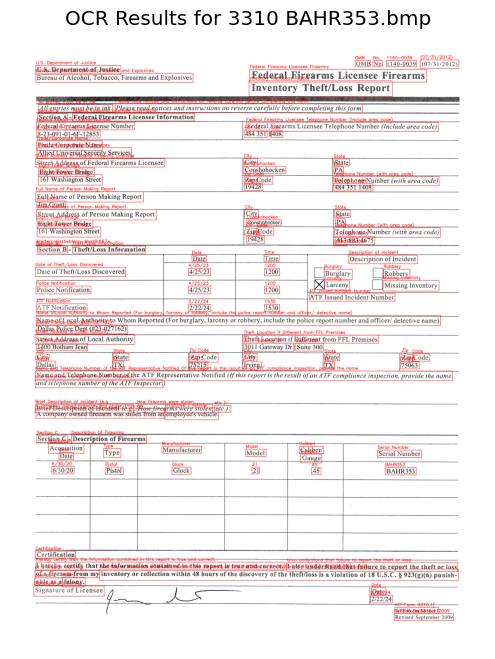

✓ Processed: 3310 BAHR353.bmp | Serial: BAHR353 | Event: Theft/Loss | Date: 4/25/23 | Name: Jim Grant | Street: 161 Washington Street | Zip: 19428 | City: Conshohocken | State: PA | CompleteAddr: 161 Washington Street, Conshohocken, PA 19428

BMP processing complete!
EXTRACTION RESULTS (CSV FORMAT)
serial_number,event_type,event_date,associated_name,associated_address,source_file,file_created,file_modified
BAHR353,Theft/Loss,4/25/23,Jim Grant,"161 Washington Street, Conshohocken, PA 19428",test/3310 BAHR353.bmp,2025-06-30 13:28:49,2025-06-30 13:28:49



In [4]:
# CELL 1.3: BMP files processing

import os
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import pandas as pd
import re
import zipcodes

# Setup
df1["filename"] = df1["filename"].astype(str)
df1["file_creation_date"] = df1["file_creation_date"].astype(str)
df1["file_modification_date"] = df1["file_modification_date"].astype(str)
df1["file_location"] = df1["file_location"].astype(str)

test_folder = os.path.join(os.getcwd(), "test")
reader = easyocr.Reader(["en"], gpu=True)
file_list = [f for f in os.listdir(test_folder) if f.lower().endswith(".bmp")]

print(f"Found {len(file_list)} BMP files in test folder")

# Initialize results list for CSV output
csv_results = []


def combine_spaced_alphanumeric(text):
    """Combine spaced alphanumeric characters that form a sequence"""
    parts = [part for part in text.split() if part]
    if len(parts) >= 3:
        single_chars = [
            part
            for part in parts
            if len(part) == 1 and (part.isalpha() or part.isdigit())
        ]
        if len(single_chars) >= 2:
            combined = "".join(parts)
            if 5 <= len(combined) <= 20 and combined.isalnum():
                return combined
    return text


def find_serial(processed_results, all_text_combined, original_results):
    """Find serial number using multiple strategies"""
    patterns = [
        r"\b[A-Z0-9]{7,12}\b",
        r"\b[A-Z0-9]{4,20}\b",
        r"\b[A-Z]{1,2}[0-9]{4,10}\b",
        r"\b[0-9]{4,15}\b",
        r"\b[A-Z]{2,10}[0-9]{2,10}\b",
        r"\b[A-Z]{3,15}\b",
        r"\b[0-9]{5,15}\b",
    ]

    # Try processed results first
    for pattern in patterns:
        for bbox, text, confidence in processed_results:
            match = re.search(pattern, text)
            if match:
                candidate = match.group()
                if (
                    5 <= len(candidate) <= 20
                    and candidate.lower()
                    not in ["image", "photo", "document", "serial", "number"]
                    and candidate.isalnum()
                ):
                    return candidate

    # Try combined text
    if all_text_combined:
        for pattern in patterns:
            match = re.search(pattern, all_text_combined)
            if match:
                candidate = match.group()
                if 5 <= len(candidate) <= 20 and candidate.isalnum():
                    return candidate

    # Try spaced reconstruction
    for bbox, text, confidence in original_results:
        if " " in text and len(text.split()) >= 3:
            parts = text.split()
            single_chars = [p for p in parts if len(p) == 1]
            if len(single_chars) >= 3:
                reconstructed = "".join(parts)
                if 5 <= len(reconstructed) <= 20 and reconstructed.isalnum():
                    return reconstructed

    return None


def extract_metadata(processed_results):
    """Extract name, address, date, zipcode, city, state, and event name"""

    # Business/organization names to exclude when looking for person names
    business_exclusions = [
        "federal",
        "firearms",
        "gun",
        "shop",
        "store",
        "company",
        "corp",
        "corporation",
        "inc",
        "incorporated",
        "llc",
        "ltd",
        "limited",
        "business",
        "enterprise",
        "arms",
        "armory",
        "tactical",
        "shooting",
        "sports",
        "outdoor",
        "hunting",
        "dealer",
        "sales",
        "supply",
        "equipment",
        "services",
        "solutions",
    ]

    results = {}
    matches = 0

    # Extract street address
    street_address = None
    address_pattern = r"\b\d{1,5}\s[A-Z][a-z]+\s[A-Z][a-z]+\b"
    for bbox, text, confidence in processed_results:
        match = re.search(address_pattern, text)
        if match:
            street_address = match.group()
            matches += 1
            break

    results["street_address"] = street_address

    # Special handling for person name extraction
    name = None
    name_candidates = []

    # Look for person name patterns (2-3 words, proper case)
    name_patterns = [
        r"\b[A-Z][a-z]+\s[A-Z][a-z]+\s[A-Z][a-z]+\b",  # First Middle Last
        r"\b[A-Z][a-z]+\s[A-Z]\.\s[A-Z][a-z]+\b",  # First M. Last
        r"\b[A-Z][a-z]+\s[A-Z][a-z]+\b",  # First Last
    ]

    for pattern in name_patterns:
        for bbox, text, confidence in processed_results:
            matches_found = re.findall(pattern, text)
            for match in matches_found:
                # Check if this looks like a person name (not business)
                match_lower = match.lower()
                is_business = any(
                    exclusion in match_lower for exclusion in business_exclusions
                )

                if not is_business and confidence > 0.7:
                    name_candidates.append((match, confidence))

    # Select the best name candidate
    if name_candidates:
        # Sort by confidence and prefer longer names (likely more complete)
        name_candidates.sort(key=lambda x: (x[1], len(x[0])), reverse=True)
        name = name_candidates[0][0]
        matches += 1

    results["name"] = name

    # Semantic event name extraction - focus on actual events, not form metadata
    event_name = None
    event_candidates = []

    # Words to exclude (organizational/administrative terms, not events)
    excluded_words = {
        "atf",
        "bureau",
        "federal",
        "department",
        "justice",
        "alcohol",
        "tobacco",
        "firearms",
        "explosives",
        "form",
        "section",
        "page",
        "number",
        "code",
        "licensee",
        "information",
        "details",
        "description",
        "brief",
        "name",
        "address",
        "telephone",
        "date",
        "time",
        "signature",
        "certification",
    }

    # PRIORITY 1: Look for document purpose indicators (what is being reported)
    purpose_patterns = [
        (
            r"(Theft|Loss|Stolen|Missing|Burglary|Robbery|Larceny).*?Report",
            "Theft/Loss",
        ),
        (r"Inventory\s+(Theft|Loss)", "Theft/Loss"),
        (
            r"(Purchase|Sale|Transfer|Registration|Acquisition|Disposition).*?Report",
            None,
        ),
    ]

    for pattern, fixed_event in purpose_patterns:
        for i, (bbox, text, confidence) in enumerate(processed_results):
            match = re.search(pattern, text, re.IGNORECASE)
            if match and confidence > 0.4:
                if fixed_event:
                    event_type = fixed_event
                else:
                    event_type = match.group(1).title()
                event_candidates.append(
                    (event_type, confidence + 1.0, "document_purpose")
                )

    # PRIORITY 2: Look for specific incident/crime types
    incident_types = {
        "burglary": "Burglary",
        "robbery": "Robbery",
        "larceny": "Larceny",
        "theft": "Theft",
        "stolen": "Theft",
        "missing": "Missing",
        "lost": "Loss",
    }

    for i, (bbox, text, confidence) in enumerate(processed_results):
        text_clean = text.lower().strip()
        if text_clean in incident_types and confidence > 0.5:
            event_candidates.append(
                (incident_types[text_clean], confidence + 0.8, "incident_type")
            )

    # PRIORITY 3: Look for action descriptions (what happened to the firearm)
    action_patterns = [
        (r"was\s+(stolen|taken|missing|lost)", None),
        (r"were\s+(stolen|taken|missing|lost)", None),
        (r"firearm\s+was\s+(\w+)", None),
        (r"gun\s+was\s+(\w+)", None),
    ]

    for pattern, _ in action_patterns:
        for i, (bbox, text, confidence) in enumerate(processed_results):
            match = re.search(pattern, text, re.IGNORECASE)
            if match and confidence > 0.6:
                action = match.group(1).lower()
                if action in incident_types:
                    event_candidates.append(
                        (incident_types[action], confidence + 0.6, "action_description")
                    )

    # PRIORITY 4: Look for section headers that indicate event type
    section_patterns = [
        (r"(Theft|Loss|Stolen|Missing)\s+Information", None),
        (r"(Purchase|Sale|Transfer)\s+Information", None),
    ]

    for pattern, _ in section_patterns:
        for i, (bbox, text, confidence) in enumerate(processed_results):
            match = re.search(pattern, text, re.IGNORECASE)
            if match and confidence > 0.6:
                event_type = match.group(1).title()
                if event_type.lower() not in excluded_words:
                    event_candidates.append(
                        (event_type, confidence + 0.4, "section_header")
                    )

    # PRIORITY 5: Look for meaningful single words (but filter out administrative terms)
    for i, (bbox, text, confidence) in enumerate(processed_results):
        text_clean = text.strip()
        if (
            len(text_clean.split()) == 1
            and len(text_clean) > 3
            and confidence > 0.7
            and text_clean.isalpha()
            and text_clean.lower() not in excluded_words
        ):
            # Check if it's a potential event type
            if text_clean.lower() in incident_types:
                event_candidates.append(
                    (
                        incident_types[text_clean.lower()],
                        confidence + 0.2,
                        "meaningful_word",
                    )
                )

    # Select the best event candidate with semantic priority
    if event_candidates:
        # Sort by: 1) Source priority (semantic importance), 2) Confidence
        priority_order = {
            "document_purpose": 5,  # Highest - what the document is for
            "incident_type": 4,  # High - specific crime/incident type
            "action_description": 3,  # Medium-high - what happened
            "section_header": 2,  # Medium - section context
            "meaningful_word": 1,  # Low - single words
        }

        event_candidates.sort(
            key=lambda x: (priority_order.get(x[2], 0), x[1]), reverse=True
        )

        event_name = event_candidates[0][0]
        matches += 1

    results["event_name"] = event_name

    # Extract event date - look for explicit event date labels, then find nearby dates
    event_date = None
    date_candidates = []

    # PRIORITY 1: Look for explicit event date labels, then find nearby dates
    event_label_patterns = [
        r"Date\s+of\s+(Theft|Loss|Stolen|Missing|Incident|Crime)",
        r"(Theft|Loss|Stolen|Missing|Incident|Crime)\s+.*?Date",
        r"When\s+.*?(stolen|lost|missing|taken)",
        r"Date.*?(Discovered|Reported|Occurred)",
    ]

    # First, find text blocks with event date labels
    event_label_positions = []
    for bbox, text, confidence in processed_results:
        for pattern in event_label_patterns:
            if re.search(pattern, text, re.IGNORECASE) and confidence > 0.4:
                text_y = min([point[1] for point in bbox])
                event_label_positions.append((text_y, text, confidence))
                break

    # Then, find dates near these labels
    if event_label_positions:
        for bbox, text, confidence in processed_results:
            date_match = re.search(r"\b\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}\b", text)
            if date_match and confidence > 0.5:
                date_y = min([point[1] for point in bbox])

                # Find the closest event label to this date
                for label_y, label_text, label_conf in event_label_positions:
                    y_distance = abs(date_y - label_y)
                    if y_distance < 150:  # Within 150 pixels of event label
                        date_candidates.append(
                            (
                                date_match.group(),
                                confidence + 1.0,
                                "explicit_event_context",
                                f"Near label: {label_text}",
                            )
                        )

    # PRIORITY 2: Look for dates near event-related text (if no explicit labels found)
    if not date_candidates:
        event_keywords = [
            "theft",
            "loss",
            "stolen",
            "missing",
            "larceny",
            "burglary",
            "incident",
        ]

        # Find text blocks containing event keywords
        event_text_positions = []
        for i, (bbox, text, confidence) in enumerate(processed_results):
            text_lower = text.lower()
            if (
                any(keyword in text_lower for keyword in event_keywords)
                and confidence > 0.5
            ):
                text_y = min([point[1] for point in bbox])
                event_text_positions.append((i, text_y, text))

        # Look for dates near event-related text
        for bbox, text, confidence in processed_results:
            date_match = re.search(r"\b\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}\b", text)
            if date_match and confidence > 0.5:
                text_y = min([point[1] for point in bbox])

                # Check if this date is near any event-related text
                for event_i, event_y, event_text in event_text_positions:
                    y_distance = abs(text_y - event_y)
                    if y_distance < 100:  # Within 100 pixels of event text
                        date_candidates.append(
                            (
                                date_match.group(),
                                confidence + 0.8,
                                "near_event_text",
                                f"Near: {event_text}",
                            )
                        )

    # PRIORITY 3: Exclude administrative dates
    administrative_keywords = [
        "atf",
        "notification",
        "form",
        "created",
        "printed",
        "letterhead",
        "bureau",
    ]

    # Filter out dates that are clearly administrative
    filtered_candidates = []
    for date_val, conf, source, context in date_candidates:
        context_lower = context.lower()
        is_administrative = any(
            admin_word in context_lower for admin_word in administrative_keywords
        )

        if not is_administrative:
            filtered_candidates.append((date_val, conf, source, context))

    # Select the best event date
    if filtered_candidates:
        # Sort by source priority, then confidence
        priority_order = {
            "explicit_event_context": 3,  # Highest - explicit event date labels
            "near_event_text": 2,  # Medium - dates near event descriptions
            "positional": 1,  # Lowest - just positional filtering
        }

        filtered_candidates.sort(
            key=lambda x: (priority_order.get(x[2], 0), x[1]), reverse=True
        )
        event_date = filtered_candidates[0][0]
        matches += 1

        # DEBUG: Uncomment to see date selection process
        # print(f"Event date selected: '{event_date}' from {filtered_candidates[0][2]} - Context: {filtered_candidates[0][3]}")

    elif date_candidates:
        # Fallback to any date found, but still avoid administrative ones
        event_date = date_candidates[0][0]
        matches += 1
    else:
        # Final fallback: any date in the document (existing logic)
        for bbox, text, confidence in processed_results:
            date_match = re.search(r"\b\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}\b", text)
            if date_match and confidence > 0.5:
                event_date = date_match.group()
                matches += 1
                break

    results["event_date"] = event_date

    # Zipcode with positional filtering
    zipcode = None
    if processed_results:
        all_y_coords = [point[1] for bbox, _, _ in processed_results for point in bbox]
        image_height = max(all_y_coords) if all_y_coords else 0
        top_boundary = image_height * 0.25
        bottom_boundary = image_height * 0.50

        candidates = []
        for bbox, text, confidence in processed_results:
            if re.match(r"\b\d{5}(-\d{4})?\b", text.strip()):
                top_y = min([point[1] for point in bbox])
                bottom_y = max([point[1] for point in bbox])
                text_center_y = (top_y + bottom_y) / 2
                if top_boundary <= text_center_y <= bottom_boundary:
                    candidates.append((text.strip(), confidence))

        if candidates:
            zipcode = max(candidates, key=lambda x: x[1])[0]
            matches += 1

    # Get city/state from zipcode
    city = state = None
    if zipcode:
        try:
            location = zipcodes.matching(str(zipcode))
            if location:
                city = location[0]["city"]
                state = location[0]["state"]
                matches += 2
        except Exception as e:
            print(f"Error looking up zipcode {zipcode}: {e}")

    # Construct complete address
    complete_address = ""
    if street_address:
        complete_address = street_address
        if city and state:
            complete_address += f", {city}, {state}"
            if zipcode:
                complete_address += f" {zipcode}"
        elif zipcode:
            complete_address += f" {zipcode}"

    results.update(
        {
            "complete_address": complete_address,
            "zipcode": zipcode,
            "city": city,
            "state": state,
            "matches": matches,
        }
    )
    return results


# Main processing loop
for filename in file_list:
    full_path = os.path.join(test_folder, filename)
    relative_path = os.path.join("test", filename)  # Create relative path
    # print(f"\nProcessing BMP: {filename}")

    try:
        # Load BMP with OpenCV and convert for EasyOCR
        img_cv = cv2.imread(full_path)
        if img_cv is not None and isinstance(img_cv, np.ndarray):
            img_for_ocr = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            results = reader.readtext(img_for_ocr)
        else:
            print(f"Failed to load BMP file {filename}")
            results = []

        # Visualize results (comment out if not needed)
        img = cv2.imread(full_path)
        if img is not None and isinstance(img, np.ndarray):
            for bbox, text, confidence in results:
                pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
                cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=2)
                x, y = pts[0][0]
                cv2.putText(
                    img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2
                )

            try:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(12, 8))
                plt.imshow(img_rgb)
                plt.axis("off")
                plt.title(f"OCR Results for {filename}")
                plt.show()
            except Exception as e:
                print(f"Warning: Could not display image {filename}")

        # Process OCR results
        processed_results = []
        for bbox, text, confidence in results:
            processed_text = combine_spaced_alphanumeric(text)
            processed_results.append((bbox, processed_text, confidence))

        all_text_combined = " ".join([text for _, text, _ in processed_results])

        # Find serial number
        serial_num = find_serial(processed_results, all_text_combined, results)

        # Extract metadata
        metadata_info = extract_metadata(processed_results)

        # Get file metadata using absolute path but store relative path
        file_metadata = get_file_metadata(full_path)

        # Create CSV record with fixed address and event date
        csv_record = {
            "serial_number": str(serial_num) if serial_num else "",
            "event_type": (
                str(metadata_info["event_name"]) if metadata_info["event_name"] else ""
            ),
            "event_date": (
                str(metadata_info["event_date"]) if metadata_info["event_date"] else ""
            ),
            "associated_name": (
                str(metadata_info["name"]) if metadata_info["name"] else ""
            ),
            "associated_address": (
                str(metadata_info["complete_address"])
                if metadata_info["complete_address"]
                else ""
            ),
            "source_file": relative_path,
            "file_created": file_metadata["file_creation_date"],
            "file_modified": file_metadata["file_modification_date"],
        }

        csv_results.append(csv_record)

        # Add to dataframe (including event_name)
        new_row = {
            "serial_number": str(serial_num) if serial_num else None,
            "name": str(metadata_info["name"]) if metadata_info["name"] else None,
            "address": (
                str(metadata_info["street_address"])
                if metadata_info["street_address"]
                else None
            ),
            "date": (
                str(metadata_info["event_date"])
                if metadata_info["event_date"]
                else None
            ),
            "zipcode": (
                str(metadata_info["zipcode"]) if metadata_info["zipcode"] else None
            ),
            "city": str(metadata_info["city"]) if metadata_info["city"] else None,
            "state": str(metadata_info["state"]) if metadata_info["state"] else None,
            "event_name": (
                str(metadata_info["event_name"])
                if metadata_info["event_name"]
                else None
            ),
        }

        df1 = pd.concat([df1, pd.DataFrame([new_row])], ignore_index=True)

        # Add file metadata to df1 with relative path
        if serial_num:
            df1.loc[df1["serial_number"] == str(serial_num), "filename"] = filename
            df1.loc[df1["serial_number"] == str(serial_num), "file_creation_date"] = (
                file_metadata["file_creation_date"]
            )
            df1.loc[
                df1["serial_number"] == str(serial_num), "file_modification_date"
            ] = file_metadata["file_modification_date"]
            df1.loc[df1["serial_number"] == str(serial_num), "file_location"] = (
                relative_path
            )

        # Enhanced detailed per-image output for control
        detail_line = (
            f'✓ Processed: {filename} | Serial: {serial_num or "None"} | '
            f'Event: {metadata_info.get("event_name") or "None"} | Date: {metadata_info.get("event_date") or "None"} | '
            f'Name: {metadata_info.get("name") or "None"} | Street: {metadata_info.get("street_address") or "None"} | '
            f'Zip: {metadata_info.get("zipcode") or "None"} | City: {metadata_info.get("city") or "None"} | State: {metadata_info.get("state") or "None"} | '
            f'CompleteAddr: {metadata_info.get("complete_address") or "None"}'
        )
        print(detail_line)

    except Exception as e:
        print(f"Error processing BMP {filename}: {e}")
        import traceback

        traceback.print_exc()

print(f"\nBMP processing complete!")

# Create and display CSV-formatted results
if csv_results:
    results_df = pd.DataFrame(csv_results)
    # print("\n" + "=" * 80)
    print("EXTRACTION RESULTS (CSV FORMAT)")
    # print("=" * 80)
    print(results_df.to_csv(index=False))

    # Create reports folder if it doesn't exist
    reports_folder = os.path.join(os.getcwd(), "reports")
    os.makedirs(reports_folder, exist_ok=True)

    # Save to file in reports folder
    output_file = os.path.join(reports_folder, "bmp_extraction_results.csv")
    results_df.to_csv(output_file, index=False)
    # print(f"\nResults saved to: {output_file}")
else:
    print("\nNo results to display.")


In [ ]:
# Cell 2: Define Shared Constants and Data Structures
# Constants for OCR processing
OCR_CONFIDENCE_THRESHOLD = 0.4

# Non-serial words (clearly NOT serial numbers)
NON_SERIAL_WORDS = {
    "date",
    "city",
    "state",
    "name",
    "address",
    "phone",
    "email",
    "zip",
    "code",
    "serial",
    "number",
    "model",
    "make",
    "caliber",
    "type",
    "manufacturer",
    # ... other common words that aren't serial numbers
}

# Event type mapping
EVENT_TYPE_MAPPING = {
    "burglary": "Burglary",
    "robbery": "Robbery",
    "larceny": "Larceny",
    "theft": "Theft",
    "stolen": "Theft",
    "missing": "Missing",
    "lost": "Loss",
}

# Regex patterns
REGEX_PATTERNS = {
    "name": r"\b[A-Z][a-z]+\s[A-Z][a-z]+\b",
    "zipcode": r"\b\d{5}(?:-\d{4})?\b",
    "date": r"\b(?:\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\d{2,4}[-/]\d{1,2}[-/]\d{1,2})\b",
    "street_address": r"\b\d+\s+[A-Za-z\s]+(?:Street|St|Avenue|Ave|Road|Rd|Boulevard|Blvd|Drive|Dr|Lane|Ln|Way|Court|Ct|Place|Pl|Terrace|Ter)\b",
}

# Standard columns for final report
STANDARD_COLUMNS = [
    "file_name",
    "serial_number",
    "event_type",
    "name",
    "address",
    "date",
    "zipcode",
    "city",
    "state",
    "creation_date",
    "modification_date",
]


In [ ]:
# Cell 3: Shared Utility Functions
# Shared utility functions for both BMP and non-BMP processing


def get_file_metadata(file_path):
    """Extract metadata from file path and properties"""
    file_name = os.path.basename(file_path)
    file_size = os.path.getsize(file_path)

    # Get file creation and modification times
    if platform.system() == "Windows":
        creation_time = os.path.getctime(file_path)
    else:
        stat = os.stat(file_path)
        try:
            creation_time = stat.st_birthtime  # macOS
        except AttributeError:
            creation_time = stat.st_mtime  # Linux

    modification_time = os.path.getmtime(file_path)

    # Format timestamps
    creation_time_str = datetime.fromtimestamp(creation_time).strftime(
        "%Y-%m-%d %H:%M:%S"
    )
    modification_time_str = datetime.fromtimestamp(modification_time).strftime(
        "%Y-%m-%d %H:%M:%S"
    )

    return {
        "file_name": file_name,
        "file_size": file_size,
        "creation_time": creation_time_str,
        "modification_time": modification_time_str,
    }


def visualize_ocr_results(image_path, ocr_results, title="OCR Results"):
    """Visualize OCR results on the image"""
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 15))
        plt.imshow(img)

        for bbox, text, prob in ocr_results:
            # Convert bbox to int coordinates
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))

            # Draw the bounding box
            cv2.rectangle(img, tl, br, (0, 255, 0), 2)

            # Put the text near the bounding box
            cv2.putText(
                img,
                text,
                (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
            )

        plt.title(title)
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error visualizing OCR results: {e}")


def generate_reports(bmp_results, other_results, output_folder):
    """Generate consolidated reports from processing results"""
    # Combine results
    all_results = bmp_results + other_results

    if not all_results:
        print("No results to generate reports from.")
        return

    # Convert to DataFrame
    df = pd.DataFrame(all_results)

    # Save raw results
    raw_output_path = os.path.join(output_folder, "raw_results.csv")
    df.to_csv(raw_output_path, index=False)
    print(f"Raw results saved to {raw_output_path}")

    # Generate full report with standardized columns
    try:
        # Standardize column names
        df_report = df.copy()

        # Ensure all expected columns exist
        expected_columns = [
            "serial_number",
            "event_type",
            "name",
            "address",
            "city",
            "state",
            "zipcode",
            "date",
            "file_name",
            "file_size",
            "creation_time",
            "modification_time",
        ]

        for col in expected_columns:
            if col not in df_report.columns:
                df_report[col] = None

        # Compose full address
        df_report["full_address"] = df_report.apply(
            lambda row: f"{row['address'] or ''}, {row['city'] or ''}, {row['state'] or ''} {row['zipcode'] or ''}".strip().strip(
                ","
            ),
            axis=1,
        )

        # Remove duplicate rows
        df_report = df_report.drop_duplicates(
            subset=["serial_number", "event_type", "name"], keep="first"
        )

        # Reorder columns
        ordered_cols = [
            "serial_number",
            "event_type",
            "name",
            "full_address",
            "address",
            "city",
            "state",
            "zipcode",
            "date",
            "file_name",
            "file_size",
            "creation_time",
            "modification_time",
        ]
        df_report = df_report[ordered_cols]

        # Save full report
        report_output_path = os.path.join(output_folder, "full_report.csv")
        df_report.to_csv(report_output_path, index=False)
        print(f"Full report saved to {report_output_path}")

        # Display report preview
        print("\nReport Preview:")
        print(df_report.head())

    except Exception as e:
        print(f"Error generating full report: {e}")


In [ ]:
# Cell 4: Create Unified OCR Interface
def run_ocr(image_path, file_type):
    """Run appropriate OCR engine based on file type"""
    if file_type == "bmp":
        # Use EasyOCR for BMP files
        try:
            print(f"Running EasyOCR on {os.path.basename(image_path)}")
            results = reader_easy.readtext(image_path)
            # EasyOCR results already in standard format
            return results
        except Exception as e:
            print(f"Error with EasyOCR: {e}")
            return []
    else:
        # Use PaddleOCR for non-BMP files
        try:
            print(f"Running PaddleOCR on {os.path.basename(image_path)}")
            results = paddle_ocr.ocr(image_path, cls=True)
            return normalize_paddle_results(results)
        except Exception as e:
            print(f"Error with PaddleOCR: {e}")
            return []


def normalize_paddle_results(paddle_raw):
    """Normalize PaddleOCR results to match the format [(bbox, text, confidence), ...]"""
    normalized = []

    if not paddle_raw or len(paddle_raw) == 0:
        return normalized

    try:
        # Handle different PaddleOCR result formats
        if isinstance(paddle_raw[0], list) and len(paddle_raw[0]) > 0:
            for line in paddle_raw[0]:
                if len(line) == 2:
                    bbox, (text, confidence) = line
                    normalized.append((bbox, text, confidence))
    except Exception as e:
        print(f"Error normalizing PaddleOCR results: {e}")

    return normalized


In [ ]:
# Cell 5: Implement Image Preprocessing Functions
def preprocess_image(image, methods=None):
    """Apply multiple preprocessing methods to an image"""
    if methods is None:
        methods = ["grayscale", "blur", "sharpen", "threshold", "morphology"]

    results = {}

    if "grayscale" in methods:
        results["grayscale"] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if "blur" in methods:
        results["blur"] = cv2.GaussianBlur(results.get("grayscale", image), (5, 5), 0)

    if "sharpen" in methods:
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        results["sharpen"] = cv2.filter2D(results.get("grayscale", image), -1, kernel)

    if "threshold" in methods:
        gray = results.get("grayscale", cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        results["threshold"] = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )

    if "morphology" in methods:
        thresh = results.get("threshold", None)
        if thresh is not None:
            kernel = np.ones((1, 1), np.uint8)
            results["morphology"] = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    return results


def run_multiple_ocr_passes(image_path):
    """Run OCR with multiple preprocessing methods to improve accuracy"""
    all_candidates = []

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return all_candidates

    # First pass: Original image
    try:
        results = paddle_ocr.ocr(image_path, cls=True)
        normalized = normalize_paddle_results(results)

        for bbox, text, confidence in normalized:
            all_candidates.append(
                {
                    "text": text.strip(),
                    "confidence": confidence,
                    "source": "original",
                    "bbox": bbox,
                }
            )
    except Exception as e:
        print(f"Error with original image OCR: {e}")

    # Additional passes with preprocessing
    preprocessed = preprocess_image(img)

    for prep_name, prep_img in preprocessed.items():
        # Skip if not a valid image for OCR
        if prep_img is None or not isinstance(prep_img, np.ndarray):
            continue

        # Save preprocessed image temporarily
        temp_path = f"temp_{prep_name}.jpg"
        try:
            cv2.imwrite(temp_path, prep_img)

            # Run OCR on preprocessed image
            results = paddle_ocr.ocr(temp_path, cls=True)
            normalized = normalize_paddle_results(results)

            # Add results to candidates
            for bbox, text, confidence in normalized:
                all_candidates.append(
                    {
                        "text": text.strip(),
                        "confidence": confidence
                        * 0.9,  # Slight penalty for preprocessed
                        "source": f"preprocessed_{prep_name}",
                        "bbox": bbox,
                    }
                )

            # Clean up temp file
            if os.path.exists(temp_path):
                os.remove(temp_path)

        except Exception as e:
            print(f"Error with {prep_name} preprocessing: {e}")
            if os.path.exists(temp_path):
                os.remove(temp_path)

    return all_candidates


In [ ]:
# Cell 6: Create Metadata Extraction Functions
def get_file_metadata(file_path):
    """Extract file metadata in a platform-agnostic way"""
    # Platform detection
    platform_name = platform.system()

    # Get basic stats
    stats = os.stat(file_path)

    # Get creation and modification times based on platform
    if platform_name == "Windows":
        creation_time = datetime.fromtimestamp(stats.st_ctime)
    elif platform_name in ["Darwin", "FreeBSD"]:
        try:
            creation_time = datetime.fromtimestamp(stats.st_birthtime)
        except AttributeError:
            creation_time = datetime.fromtimestamp(stats.st_ctime)
    else:  # Linux and others
        creation_time = datetime.fromtimestamp(stats.st_ctime)

    modification_time = datetime.fromtimestamp(stats.st_mtime)

    return {
        "file_path": file_path,
        "file_name": os.path.basename(file_path),
        "creation_date": creation_time.strftime("%Y-%m-%d %H:%M:%S"),
        "modification_date": modification_time.strftime("%Y-%m-%d %H:%M:%S"),
        "platform": platform_name,
    }


def extract_serial_number(ocr_results, image_path, file_type=None):
    """Extract serial number from OCR results with improved accuracy"""
    # Convert OCR results to candidate format if needed
    if (
        isinstance(ocr_results, list)
        and len(ocr_results) > 0
        and isinstance(ocr_results[0], tuple)
    ):
        candidates = [
            {
                "text": text,
                "confidence": confidence,
                "source": "direct_ocr",
                "bbox": bbox,
            }
            for bbox, text, confidence in ocr_results
        ]
    else:
        candidates = ocr_results

    # If no candidates from direct OCR, run multiple passes
    if not candidates and image_path:
        candidates = run_multiple_ocr_passes(image_path)

    # Find potential serials
    potential_serials = []
    for candidate in candidates:
        text = candidate["text"]
        confidence = candidate["confidence"]
        source = candidate["source"]

        # Clean and filter
        cleaned = "".join(c for c in text if c.isalnum())
        if cleaned.lower() in NON_SERIAL_WORDS or (
            cleaned.isalpha() and len(cleaned) <= 8
        ):
            continue

        # Check if it could be a serial (basic length check)
        if 4 <= len(cleaned) <= 15 and cleaned.isalnum():
            # Boost confidence for mixed alphanumeric
            has_letters = any(c.isalpha() for c in cleaned)
            has_numbers = any(c.isdigit() for c in cleaned)
            if has_letters and has_numbers:
                confidence *= 1.2
            elif len(cleaned) >= 6:
                confidence *= 1.1

            potential_serials.append(
                {
                    "serial": cleaned,
                    "original_text": text,
                    "confidence": confidence,
                    "source": source,
                    "bbox": candidate["bbox"],
                }
            )

        # Try spaced character reconstruction
        if " " in text and len(text.split()) >= 3:
            parts = [p.strip() for p in text.split() if p.strip().isalnum()]
            if len(parts) >= 3:
                reconstructed = "".join(parts)
                if (
                    4 <= len(reconstructed) <= 15
                    and reconstructed.isalnum()
                    and reconstructed.lower() not in NON_SERIAL_WORDS
                ):
                    potential_serials.append(
                        {
                            "serial": reconstructed,
                            "original_text": text,
                            "confidence": confidence * 0.8,
                            "source": f"{source}_reconstructed",
                            "bbox": candidate["bbox"],
                        }
                    )

    # Remove duplicates and sort by confidence
    unique_serials = {}
    for serial_info in potential_serials:
        serial = serial_info["serial"]
        if (
            serial not in unique_serials
            or serial_info["confidence"] > unique_serials[serial]["confidence"]
        ):
            unique_serials[serial] = serial_info

    # Sort by confidence
    sorted_serials = sorted(
        unique_serials.values(), key=lambda x: x["confidence"], reverse=True
    )

    # Display top candidates
    print(f"\nSerial number candidates found:")
    if sorted_serials:
        for i, serial_info in enumerate(sorted_serials[:5]):  # Show top 5
            marker = "→ SELECTED" if i == 0 else "  "
            print(
                f"  {marker} '{serial_info['serial']}' (confidence: {serial_info['confidence']:.3f})"
            )
        return sorted_serials[0]["serial"]
    else:
        print("  No potential serial numbers found")
        return None


def extract_event_type_semantic(results):
    """Extract event type with semantic priorities"""
    event_candidates = []

    # Priority 1: Document purpose indicators
    for _, text, conf in results:
        m = re.search(
            r"(Theft|Loss|Stolen|Missing|Burglary|Robbery|Larceny).*?Report",
            text,
            re.IGNORECASE,
        )
        if m and conf > 0.4:
            event_candidates.append(
                ("Theft/Loss", conf + 1.0, "document_purpose", text)
            )

    # Priority 2: Specific incident/crime types
    for _, text, conf in results:
        text_clean = text.lower().strip()
        if text_clean in EVENT_TYPE_MAPPING and conf > 0.5:
            event_candidates.append(
                (EVENT_TYPE_MAPPING[text_clean], conf + 0.8, "incident_type", text)
            )

    # Priority 3: Action descriptions
    for _, text, conf in results:
        if conf < 0.3:
            continue
        text_lower = text.lower()
        if "stolen" in text_lower or "theft" in text_lower:
            event_candidates.append(("Theft", conf + 0.5, "action_description", text))
        elif "lost" in text_lower or "missing" in text_lower:
            event_candidates.append(("Loss", conf + 0.5, "action_description", text))
        elif "burglary" in text_lower:
            event_candidates.append(
                ("Burglary", conf + 0.5, "action_description", text)
            )
        elif "robbery" in text_lower:
            event_candidates.append(("Robbery", conf + 0.5, "action_description", text))

    # Priority 4: Section headers
    for _, text, conf in results:
        if conf < 0.4:
            continue
        if re.search(r"^(Type|Event|Incident)[\s:]", text, re.IGNORECASE):
            for event_type in EVENT_TYPE_MAPPING.values():
                if event_type.lower() in text.lower():
                    event_candidates.append(
                        (event_type, conf + 0.3, "section_header", text)
                    )

    # Priority 5: Meaningful words in context
    for _, text, conf in results:
        if conf < 0.5:
            continue
        for word, event_type in EVENT_TYPE_MAPPING.items():
            if word in text.lower():
                event_candidates.append((event_type, conf, "meaningful_word", text))

    if not event_candidates:
        return None

    # Sort by priority and confidence
    priority_order = {
        "document_purpose": 5,
        "incident_type": 4,
        "action_description": 3,
        "section_header": 2,
        "meaningful_word": 1,
    }

    event_candidates.sort(
        key=lambda x: (priority_order.get(x[2], 0), x[1]), reverse=True
    )

    # Print top candidates
    print(f"\nEvent type candidates found:")
    for i, (event_type, conf, source, text) in enumerate(event_candidates[:3]):
        if i == 0:
            print(
                f"  → SELECTED '{event_type}' (confidence: {conf:.3f}, source: {source})"
            )
        else:
            print(f"    '{event_type}' (confidence: {conf:.3f}, source: {source})")

    return event_candidates[0][0]


def extract_metadata(ocr_results):
    """Extract metadata from OCR results"""
    metadata = {
        "name": None,
        "address": None,
        "date": None,
        "zipcode": None,
        "city": None,
        "state": None,
    }

    # Name extraction
    for _, text, confidence in ocr_results:
        match = re.search(REGEX_PATTERNS["name"], text)
        if match and confidence > 0.8:
            metadata["name"] = match.group()
            break

    # Zipcode extraction
    for _, text, confidence in ocr_results:
        match = re.search(REGEX_PATTERNS["zipcode"], text)
        if match and confidence > 0.7:
            metadata["zipcode"] = match.group()

            # Try to get city and state from zipcode
            try:
                # Using zipcodes module instead of zipcode
                zip_info = zipcodes.matching(metadata["zipcode"])
                if zip_info and len(zip_info) > 0:
                    metadata["city"] = zip_info[0]["city"]
                    metadata["state"] = zip_info[0]["state"]
            except Exception as e:
                print(f"Error looking up zipcode: {e}")
            break

    # Address extraction
    for _, text, confidence in ocr_results:
        match = re.search(REGEX_PATTERNS["street_address"], text)
        if match and confidence > 0.6:
            metadata["address"] = match.group()
            break

    # Date extraction
    for _, text, confidence in ocr_results:
        match = re.search(REGEX_PATTERNS["date"], text)
        if match and confidence > 0.7:
            metadata["date"] = match.group()
            break

    # Print extracted metadata
    print("\nExtracted metadata:")
    for key, value in metadata.items():
        if value:
            print(f"  {key}: {value}")

    return metadata


Found 6 total image files
Found 1 BMP files

Processing BMP file: /Users/nikolay_tishchenko/Projects/codeium/allied/test/3310 BAHR353.bmp

Serial Number Candidates:
  → SELECTED 'BAHR353' (confidence: 0.999, method: pattern_match)
     'BAHR353' (confidence: 0.999, method: pattern_match)
     'BAHR353' (confidence: 0.999, method: pattern_match)
     'BAHR353' (confidence: 0.999, method: pattern_match)
     'BAHR353' (confidence: 0.999, method: pattern_match)
     'BAHR353' (confidence: 0.999, method: pattern_match)

Event Type Candidates:
  → SELECTED 'Theft/Loss' (confidence: 1.466, method: theft_loss_section)

Date Candidates:
  → SELECTED '2/22/24' (confidence: 1.000, method: general_date)
     '4/25/23' (confidence: 1.000, method: general_date)
     '4/25/23' (confidence: 1.000, method: general_date)
     '6/30/20' (confidence: 1.000, method: general_date)
     '4/25/23' (confidence: 1.000, method: general_date)
     '4/25/23' (confidence: 1.000, method: general_date)
     '4/25/23

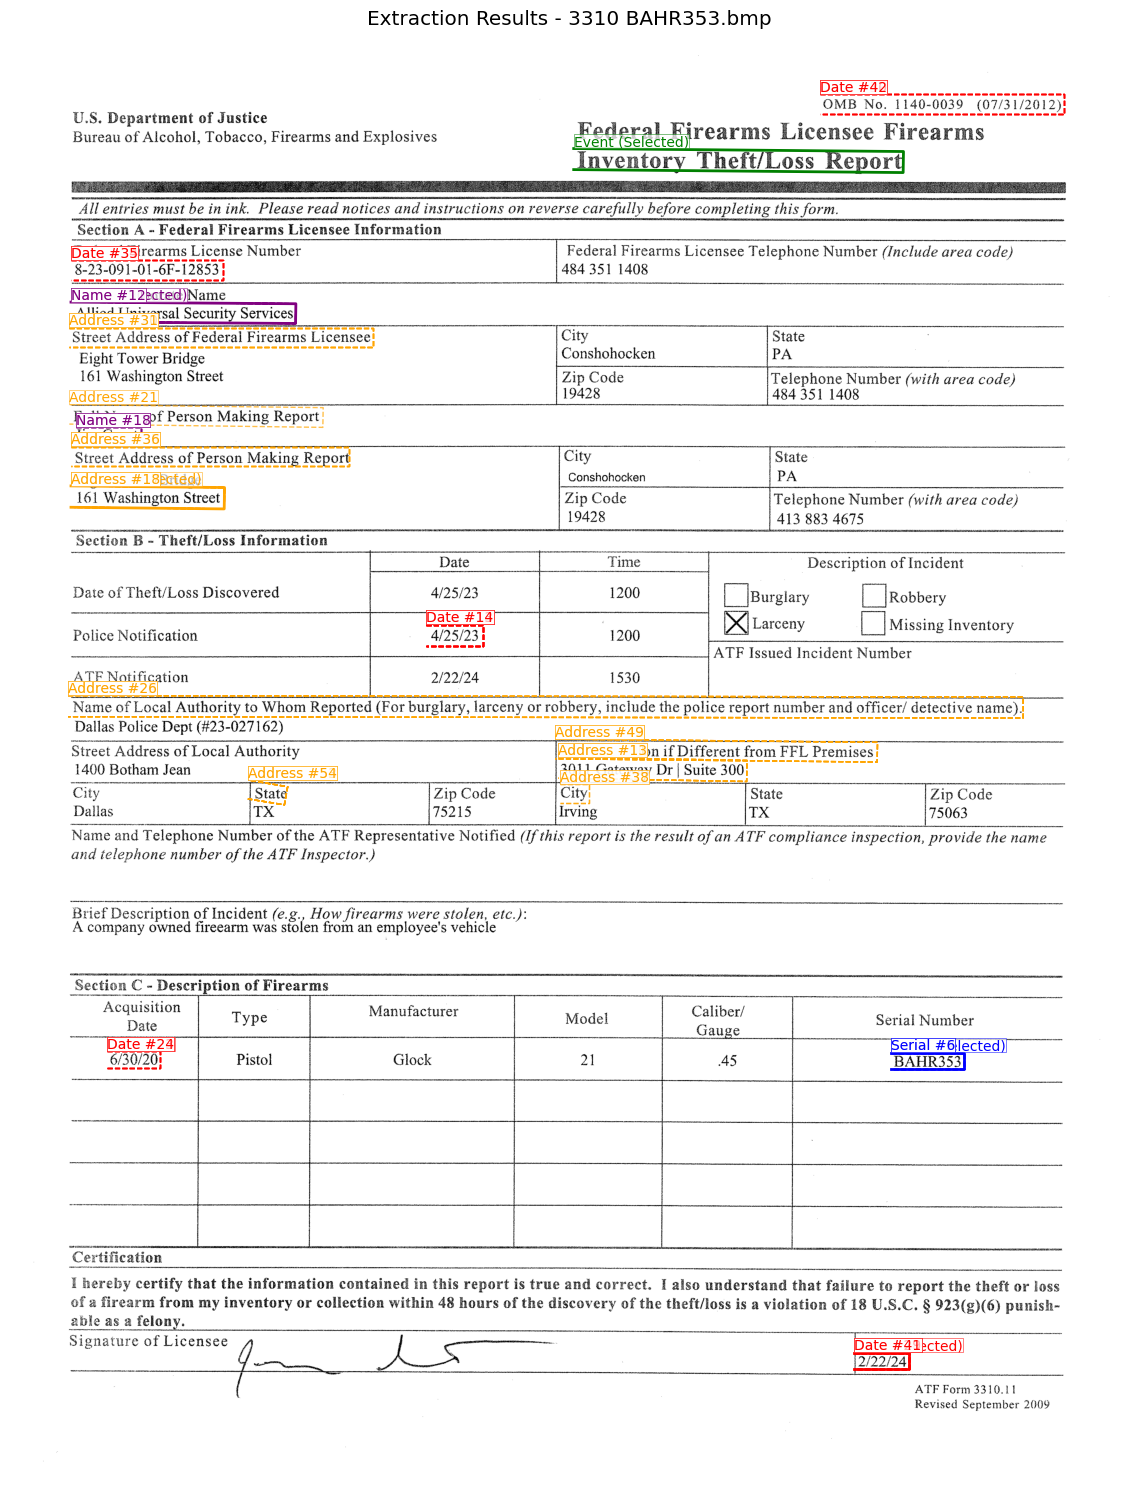

Added results for /Users/nikolay_tishchenko/Projects/codeium/allied/test/3310 BAHR353.bmp

BMP results saved to /Users/nikolay_tishchenko/Projects/codeium/allied/reports/bmp_results.csv

Extracted Information:
serial_number event_type   event_date associated_name      associated_address                       source_file          file_created file_modified
----------------------------------------------------------------------------------------------------
BAHR353      Theft/Loss   2/22/24    Allied Universal Sec 161 Washington Street                    3310 BAHR353.bmp     06/30/25 13:28 06/30/25 13:28


In [5]:
# Cell 7: BMP File Processing with PaddleOCR

import os
import cv2
import re
import pandas as pd
import numpy as np
import traceback
import glob
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
from paddleocr import PaddleOCR
import platform
import time

# Define the folder to search for images if not already defined
if "test_folder" not in locals():
    test_folder = "test"  # Default test folder

# Define reports folder if not already defined
if "reports_folder" not in locals():
    reports_folder = "reports"  # Default reports folder
    os.makedirs(reports_folder, exist_ok=True)

# Find all image files in the test folder if not already defined
if "image_files" not in locals():
    supported_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"]
    image_files = []
    for ext in supported_extensions:
        image_files.extend(glob.glob(os.path.join(test_folder, f"*{ext}")))
    print(f"Found {len(image_files)} total image files")

# Main BMP processing code
bmp_files = [f for f in image_files if f.lower().endswith(".bmp")]
print(f"Found {len(bmp_files)} BMP files")

# Initialize dataframe for BMP files if not already created
if "bmp_results_df" not in locals():
    # Use the exact column names that will be used throughout the code
    bmp_results_df = pd.DataFrame(
        columns=[
            "serial_number",
            "event_type",
            "event_date",
            "associated_name",
            "associated_address",
            "source_file",
            "file_created",
            "file_modified",
        ]
    )


# Function to extract file metadata
def extract_file_metadata(file_path):
    try:
        file_stats = os.stat(file_path)

        # Get file creation time - platform specific
        if platform.system() == "Windows":
            creation_time = datetime.fromtimestamp(file_stats.st_ctime).strftime(
                "%m/%d/%y %H:%M"
            )
        else:  # macOS and Linux
            try:
                # On macOS, st_birthtime is available
                if hasattr(file_stats, "st_birthtime"):
                    creation_time = datetime.fromtimestamp(
                        file_stats.st_birthtime
                    ).strftime("%m/%d/%y %H:%M")
                else:
                    # Fallback to ctime if birthtime is not available
                    creation_time = datetime.fromtimestamp(
                        file_stats.st_ctime
                    ).strftime("%m/%d/%y %H:%M")
            except AttributeError:
                creation_time = datetime.fromtimestamp(file_stats.st_ctime).strftime(
                    "%m/%d/%y %H:%M"
                )

        # Get file modification time
        modification_time = datetime.fromtimestamp(file_stats.st_mtime).strftime(
            "%m/%d/%y %H:%M"
        )

        # Ensure creation time is not after modification time
        # If it is, swap them (this can happen due to file system peculiarities)
        creation_dt = datetime.strptime(creation_time, "%m/%d/%y %H:%M")
        modification_dt = datetime.strptime(modification_time, "%m/%d/%y %H:%M")

        if creation_dt > modification_dt:
            creation_time, modification_time = modification_time, creation_time

        return creation_time, modification_time
    except Exception as e:
        print(f"Error extracting metadata for {file_path}: {e}")
        return None, None


# Function to preprocess image for better OCR
def preprocess_image_for_ocr(image_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return None

    # Create a list of preprocessed images
    preprocessed_images = []

    # Original image
    preprocessed_images.append(("original", img))

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    preprocessed_images.append(("grayscale", gray))

    # Threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    preprocessed_images.append(("threshold", thresh))

    # Adaptive threshold
    adaptive_thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    preprocessed_images.append(("adaptive_threshold", adaptive_thresh))

    # Blur + threshold
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, blur_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    preprocessed_images.append(("blur_threshold", blur_thresh))

    # Sharpen
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(gray, -1, kernel)
    preprocessed_images.append(("sharpened", sharpened))

    return preprocessed_images


# Function to visualize OCR results with bounding boxes on original image
def visualize_best_candidates(
    image,
    ocr_results,
    serial_candidates,
    event_candidates,
    date_candidates,
    name_candidates,
    address_candidates,
    title="Extraction Results",
):
    """Visualize highest confidence candidates with bounding boxes on the original image"""
    # Make a copy of the image to avoid modifying the original
    if len(image.shape) == 2:  # If grayscale
        display_img = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    else:
        display_img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

    # Create a figure
    plt.figure(figsize=(15, 15))
    plt.imshow(display_img)

    # Define colors for different entity types - using named colors for matplotlib
    colors = {
        "serial": "blue",
        "event": "green",
        "date": "red",
        "name": "purple",
        "address": "orange",
    }

    # Create a mapping of text to bounding boxes from OCR results
    text_to_bbox = {}
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, _) = line
            text_to_bbox[text.strip()] = bbox

    # Function to find and draw bounding boxes for all candidates
    def find_and_draw_boxes(candidates, color_key, label_prefix):
        if not candidates:
            return

        # Draw boxes for all candidates
        for i, (text, conf, method) in enumerate(candidates):
            # Try to find exact match first
            bbox = None
            for ocr_text, box in text_to_bbox.items():
                if text in ocr_text or ocr_text in text:
                    bbox = box
                    break

            if bbox:
                # Convert points to numpy array
                points = np.array(bbox, dtype=np.int32)

                # Draw polygon - solid line for selected, dashed for others
                if i == 0:  # Selected candidate
                    plt.plot(
                        points[:, 0],
                        points[:, 1],
                        color=colors[color_key],
                        linewidth=2,
                        linestyle="-",
                    )
                    label = f"{label_prefix} (Selected)"
                else:  # Other candidates
                    plt.plot(
                        points[:, 0],
                        points[:, 1],
                        color=colors[color_key],
                        linewidth=1,
                        linestyle="--",
                        alpha=0.7,
                    )
                    label = f"{label_prefix} #{i+1}"

                # Add small label near the box
                min_x = min(p[0] for p in bbox)
                min_y = min(p[1] for p in bbox)
                plt.text(
                    min_x,
                    min_y - 10,
                    label,
                    color=colors[color_key],
                    fontsize=10,
                    bbox=dict(
                        facecolor="white", alpha=0.7, edgecolor=colors[color_key], pad=0
                    ),
                )

    # Draw boxes for each entity type
    find_and_draw_boxes(serial_candidates, "serial", "Serial")
    find_and_draw_boxes(event_candidates, "event", "Event")
    find_and_draw_boxes(date_candidates, "date", "Date")
    find_and_draw_boxes(name_candidates, "name", "Name")
    find_and_draw_boxes(address_candidates, "address", "Address")

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Function to extract serial number from OCR results
def extract_serial_number(ocr_results):
    potential_serials = []

    # Extract text from OCR results
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line

            # Clean text
            text = text.strip()

            # Look for "Serial Number" label specifically
            if "Serial Number" in text:
                # Check if the serial number is in the same text after the label
                match = re.search(
                    r"Serial\s*Number[:\s]*([A-Z0-9\-]{4,})", text, re.IGNORECASE
                )
                if match:
                    potential_serials.append(
                        (match.group(1), confidence * 1.5, "serial_number_label")
                    )
                    continue

            # Look for standalone serial number patterns
            if re.match(r"^[A-Z0-9]{2,}[\-][A-Z0-9]{2,}$", text) or re.match(
                r"^[A-Z][A-Z0-9]{5,}$", text
            ):
                if not any(
                    word.lower() in text.lower()
                    for word in ["serial", "number", "date", "name", "address"]
                ):
                    potential_serials.append((text, confidence, "pattern_match"))

    # Sort by confidence and method priority
    potential_serials.sort(
        key=lambda x: (0 if "serial_number_label" in x[2] else 1, x[1]), reverse=True
    )

    # Print candidates
    print("\nSerial Number Candidates:")
    for i, (serial, conf, method) in enumerate(potential_serials):
        marker = "→ SELECTED" if i == 0 else "  "
        print(f"  {marker} '{serial}' (confidence: {conf:.3f}, method: {method})")

    return (
        potential_serials[0][0] if potential_serials else "Unknown"
    ), potential_serials


# Function to extract event type
def extract_event_type(ocr_results):
    event_candidates = []

    # First look for "Theft/Loss Information" section
    theft_loss_section_found = False
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if "Theft/Loss Information" in text:
                theft_loss_section_found = True
                event_candidates.append(
                    ("Theft/Loss", confidence * 1.5, "theft_loss_section")
                )
                break

    # If section found, prioritize it
    if theft_loss_section_found:
        # Sort by confidence
        event_candidates.sort(key=lambda x: x[1], reverse=True)

        # Print candidates
        print("\nEvent Type Candidates:")
        for i, (event, conf, method) in enumerate(event_candidates):
            marker = "→ SELECTED" if i == 0 else "  "
            print(f"  {marker} '{event}' (confidence: {conf:.3f}, method: {method})")

        return (
            event_candidates[0][0] if event_candidates else "Unknown"
        ), event_candidates

    # If section not found, look for other indicators
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            # Look for theft/loss indicators
            if re.search(r"theft|loss|stolen", text, re.IGNORECASE):
                event_candidates.append(("Theft/Loss", confidence, "keyword"))

            # Look for transfer indicators
            elif re.search(r"transfer", text, re.IGNORECASE):
                event_candidates.append(("Transfer", confidence, "keyword"))

    # Sort by confidence
    event_candidates.sort(key=lambda x: x[1], reverse=True)

    # Print candidates
    print("\nEvent Type Candidates:")
    for i, (event, conf, method) in enumerate(event_candidates):
        marker = "→ SELECTED" if i == 0 else "  "
        print(f"  {marker} '{event}' (confidence: {conf:.3f}, method: {method})")

    return event_candidates[0][0] if event_candidates else "Unknown", event_candidates


# Function to extract date
def extract_date(ocr_results):
    date_candidates = []
    date_pattern = r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{2,4}\b"

    # First look for "Date of Theft/Loss Discovered" specifically
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if "Date of Theft/Loss Discovered" in text:
                match = re.search(date_pattern, text)
                if match:
                    date_candidates.append(
                        (match.group(0), confidence * 2.0, "theft_loss_discovered_date")
                    )
                    continue

    # Then look for "Date of Theft/Loss"
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if "Date of Theft/Loss" in text and "Discovered" not in text:
                match = re.search(date_pattern, text)
                if match:
                    date_candidates.append(
                        (match.group(0), confidence * 1.5, "theft_loss_date")
                    )
                    continue

    # Then look for any dates
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            match = re.search(date_pattern, text)
            if match:
                date_candidates.append((match.group(0), confidence, "general_date"))

    # Sort by confidence and method priority
    date_candidates.sort(
        key=lambda x: (
            (
                0
                if x[2] == "theft_loss_discovered_date"
                else 1 if x[2] == "theft_loss_date" else 2
            ),
            x[1],
        ),
        reverse=True,
    )

    # Print candidates
    print("\nDate Candidates:")
    for i, (date, conf, method) in enumerate(date_candidates):
        marker = "→ SELECTED" if i == 0 else "  "
        print(f"  {marker} '{date}' (confidence: {conf:.3f}, method: {method})")

    return date_candidates[0][0] if date_candidates else "Unknown", date_candidates


# Function to extract name
def extract_name(ocr_results):
    name_candidates = []

    # First look for "Full Name of Person Making Report" specifically
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if "Full Name of Person Making Report" in text:
                # Check if name is in the same line
                match = re.search(
                    r"Full Name of Person Making Report[:\s]*(.+)", text, re.IGNORECASE
                )
                if match:
                    name_candidates.append(
                        (match.group(1), confidence * 2.0, "person_making_report")
                    )
                continue

    # Look for lines after "Full Name of Person Making Report"
    found_label = False
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if (
                found_label
                and text
                and not re.search(r"^\d+$", text)
                and not re.search(r"address|street|city|state|zip", text, re.IGNORECASE)
            ):
                name_candidates.append(
                    (text, confidence * 1.8, "after_person_making_report")
                )
                found_label = False
                continue

            if "Full Name of Person Making Report" in text:
                found_label = True

    # Then look for "Trade/Corporate Name" as fallback
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if "Trade/Corporate Name" in text:
                # Check if name is in the same line
                match = re.search(
                    r"Trade/Corporate Name[:\s]*(.+)", text, re.IGNORECASE
                )
                if match:
                    name_candidates.append(
                        (match.group(1), confidence * 1.5, "trade_name_label")
                    )
                continue

    # Look for lines after "Trade/Corporate Name"
    found_label = False
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if found_label and text and not re.search(r"^\d+$", text):
                name_candidates.append((text, confidence * 1.3, "after_trade_name"))
                found_label = False
                continue

            if "Trade/Corporate Name" in text:
                found_label = True

    # Look for company-like names
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if re.search(r"(?:Inc|LLC|Corp|Company|Services)$", text, re.IGNORECASE):
                name_candidates.append((text, confidence, "company_pattern"))

    # Sort by confidence and method priority
    name_candidates.sort(
        key=lambda x: (
            (
                0
                if "person_making_report" in x[2]
                else (
                    1
                    if "after_person_making_report" in x[2]
                    else 2 if "trade_name" in x[2] else 3
                )
            ),
            x[1],
        ),
        reverse=True,
    )

    # Print candidates
    print("\nName Candidates:")
    for i, (name, conf, method) in enumerate(name_candidates):
        marker = "→ SELECTED" if i == 0 else "  "
        print(f"  {marker} '{name}' (confidence: {conf:.3f}, method: {method})")

    return name_candidates[0][0] if name_candidates else "Unknown", name_candidates


# Function to extract address
def extract_address(ocr_results):
    address_candidates = []

    # First look for complete address patterns
    for i, line in enumerate(ocr_results):
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            # Look for city, state, zip pattern
            if re.search(r"[A-Za-z]+,\s*[A-Z]{2}\s*\d{5}", text):
                # Check if there's a street address in the previous line
                if i > 0 and len(ocr_results[i - 1]) == 2:
                    prev_bbox, (prev_text, _) = ocr_results[i - 1]
                    prev_text = prev_text.strip()

                    # Check if previous line looks like a street address
                    if re.search(r"\d+\s+[A-Za-z]+", prev_text):
                        full_address = f"{prev_text}, {text}"
                        address_candidates.append(
                            (full_address, confidence * 2.0, "complete_address")
                        )
                        continue

                # If no street address found, just use this line
                address_candidates.append((text, confidence * 1.5, "city_state_zip"))

    # Look for "Street Address" specifically
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if "Street Address" in text:
                # Check if address is in the same line
                match = re.search(r"Street Address[:\s]*(.+)", text, re.IGNORECASE)
                if match:
                    address_candidates.append(
                        (match.group(1), confidence * 1.5, "street_addr_label")
                    )
                continue

    # Look for lines after "Street Address"
    found_label = False
    street_address = ""
    for i, line in enumerate(ocr_results):
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            if found_label and text:
                street_address = text

                # Try to find city, state, zip in next line
                if i + 1 < len(ocr_results) and len(ocr_results[i + 1]) == 2:
                    next_bbox, (next_text, next_conf) = ocr_results[i + 1]
                    next_text = next_text.strip()

                    if re.search(r"[A-Za-z]+,\s*[A-Z]{2}\s*\d{5}", next_text):
                        full_address = f"{text}, {next_text}"
                        address_candidates.append(
                            (full_address, confidence * 1.8, "street_and_city")
                        )
                    else:
                        address_candidates.append(
                            (text, confidence * 1.3, "after_street_addr")
                        )
                else:
                    address_candidates.append(
                        (text, confidence * 1.3, "after_street_addr")
                    )

                found_label = False
                continue

            if "Street Address" in text:
                found_label = True

    # Look for address patterns
    for line in ocr_results:
        if len(line) == 2:  # PaddleOCR format
            bbox, (text, confidence) = line
            text = text.strip()

            # Street address pattern
            if re.search(
                r"\d+\s+[A-Za-z]+\s+(?:St|Ave|Blvd|Rd|Road|Street|Avenue|Drive|Dr|Lane|Ln)",
                text,
                re.IGNORECASE,
            ):
                address_candidates.append((text, confidence, "address_pattern"))

    # Sort by confidence and method priority
    address_candidates.sort(
        key=lambda x: (
            (
                0
                if "complete_address" in x[2]
                else (
                    1
                    if "street_and_city" in x[2]
                    else (
                        2
                        if "street_addr" in x[2]
                        else 3 if "city_state_zip" in x[2] else 4
                    )
                )
            ),
            x[1],
        ),
        reverse=True,
    )

    # Print candidates
    print("\nAddress Candidates:")
    for i, (addr, conf, method) in enumerate(address_candidates):
        marker = "→ SELECTED" if i == 0 else "  "
        print(f"  {marker} '{addr}' (confidence: {conf:.3f}, method: {method})")

    return (
        address_candidates[0][0] if address_candidates else "Unknown"
    ), address_candidates


# Initialize PaddleOCR if not already done
if "paddle_ocr" not in locals() or paddle_ocr is None:
    try:
        paddle_ocr = PaddleOCR(use_angle_cls=True, lang="en", show_log=False)
        print("PaddleOCR initialized successfully")
    except Exception as e:
        print(f"Error initializing PaddleOCR: {e}")
        paddle_ocr = None

# Process each BMP file
for file_path in bmp_files:
    try:
        print(f"\nProcessing BMP file: {file_path}")

        # Get preprocessed images
        preprocessed_images = preprocess_image_for_ocr(file_path)
        if not preprocessed_images:
            print(f"Error preprocessing {file_path}")
            continue

        all_results = []
        best_image = None
        best_image_name = ""
        best_confidence_sum = 0

        # Run OCR on each preprocessed image
        for prep_name, prep_img in preprocessed_images:
            # Save preprocessed image temporarily for PaddleOCR
            with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as temp:
                temp_path = temp.name
                cv2.imwrite(temp_path, prep_img)

            try:
                # Run PaddleOCR
                results = paddle_ocr.ocr(temp_path, cls=True)

                if results and len(results) > 0:
                    # Calculate confidence sum for this preprocessing method
                    confidence_sum = sum(conf for _, (_, conf) in results[0])

                    # Keep track of the best preprocessing method
                    if confidence_sum > best_confidence_sum:
                        best_confidence_sum = confidence_sum
                        best_image = prep_img
                        best_image_name = prep_name

                    # Add to all results
                    all_results.extend(results[0])
            except Exception as e:
                print(f"Error running OCR on {prep_name} image: {e}")

            # Clean up temp file
            if os.path.exists(temp_path):
                os.remove(temp_path)

        if not all_results:
            print(f"No OCR results found for {file_path}")
            continue

        # Extract metadata with candidates
        serial_number, serial_candidates = extract_serial_number(all_results)
        event_type, event_candidates = extract_event_type(all_results)
        date, date_candidates = extract_date(all_results)
        name, name_candidates = extract_name(all_results)
        address, address_candidates = extract_address(all_results)

        # Visualize best candidates on the original image
        original_image = cv2.imread(file_path)
        if original_image is not None:
            print(f"\nShowing extraction results on original image with bounding boxes")
            visualize_best_candidates(
                original_image,
                all_results,
                serial_candidates,
                event_candidates,
                date_candidates,
                name_candidates,
                address_candidates,
                f"Extraction Results - {os.path.basename(file_path)}",
            )

        # Extract file metadata
        creation_time, modification_time = extract_file_metadata(file_path)

        # Add to dataframe
        new_row = {
            "serial_number": serial_number,
            "event_type": event_type,
            "event_date": date,
            "associated_name": name,
            "associated_address": address,
            "source_file": os.path.basename(file_path),
            "file_created": creation_time,
            "file_modified": modification_time,
        }

        # Check if this file is already in the dataframe - use the correct column name 'source_file'
        if os.path.basename(file_path) not in bmp_results_df["source_file"].values:
            bmp_results_df = pd.concat(
                [bmp_results_df, pd.DataFrame([new_row])], ignore_index=True
            )
            print(f"Added results for {file_path}")
        else:
            print(f"File {file_path} already processed, skipping")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        traceback.print_exc()

# Save results to CSV
if not bmp_results_df.empty:
    csv_path = os.path.join(reports_folder, "bmp_results.csv")
    bmp_results_df.to_csv(csv_path, index=False)
    print(f"\nBMP results saved to {csv_path}")

    # Display results in a nice format
    print("\nExtracted Information:")
    print("=" * 100)
    print(
        f"{'serial_number':<12} {'event_type':<12} {'event_date':<10} {'associated_name':<20} {'associated_address':<40} {'source_file':<20} {'file_created':<12} {'file_modified':<12}"
    )
    print("-" * 100)
    for _, row in bmp_results_df.iterrows():
        print(
            f"{row['serial_number']:<12} {row['event_type']:<12} {row['event_date']:<10} {row['associated_name'][:20]:<20} {row['associated_address'][:40]:<40} {row['source_file']:<20} {row['file_created']:<12} {row['file_modified']:<12}"
        )
    print("=" * 100)
else:
    print("No BMP files were processed successfully.")


In [ ]:
# CELL 7: BMP files processing
# Process BMP files separately using EasyOCR
import os
import cv2
import numpy as np
import re
import pandas as pd
import easyocr
import glob

# Define the folder to search for images if not already defined
if "test_folder" not in locals():
    test_folder = "test"  # Default test folder

# Define reports folder if not already defined
if "reports_folder" not in locals():
    reports_folder = "results"
    # Create the folder if it doesn't exist
    if not os.path.exists(reports_folder):
        os.makedirs(reports_folder)

# Define report columns if not already defined
if "report_columns" not in locals():
    report_columns = [
        "filename",
        "filepath",
        "serial_number",
        "serial_confidence",
        "event_type",
        "name",
        "address",
        "date",
        "zipcode",
        "city",
        "state",
        "creation_time",
        "modification_time",
        "file_size",
        "ocr_engine",
    ]

# Initialize EasyOCR reader if not already initialized
if "reader" not in locals():
    try:
        reader = easyocr.Reader(["en"])
    except Exception as e:
        print(f"Error initializing EasyOCR: {str(e)}")
        reader = None

# Find all image files in the test folder if not already defined
if "image_files" not in locals():
    supported_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"]
    image_files = []
    for ext in supported_extensions:
        image_files.extend(glob.glob(os.path.join(test_folder, f"*{ext}")))

# Process BMP files separately
bmp_files = [f for f in image_files if f.lower().endswith(".bmp")]
print(f"Found {len(bmp_files)} BMP files")

# Initialize dataframe for BMP files if not already created
if "df1" not in locals():
    df1 = pd.DataFrame(columns=report_columns)

# Process each BMP file
for img_path in bmp_files:
    try:
        print(f"Processing BMP file: {img_path}")

        # Get file metadata using shared utility function
        file_metadata = get_file_metadata(img_path)

        # Load BMP with OpenCV and convert for EasyOCR
        img_cv = cv2.imread(img_path)
        if img_cv is not None and isinstance(img_cv, np.ndarray):
            img_for_ocr = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            try:
                if reader is not None:
                    results = reader.readtext(img_for_ocr)
                else:
                    print(f"Skipping {img_path} - EasyOCR not initialized")
                    continue
            except Exception as e:
                print(f"Error processing {img_path} with EasyOCR: {str(e)}")
                continue
        else:
            print(f"Failed to load BMP file {img_path}")
            continue

        # Extract text and confidence from OCR results
        texts = []
        confidences = []
        boxes = []

        for detection in results:
            box, text, confidence = detection
            texts.append(text)
            confidences.append(confidence)
            boxes.append(box)

        # Extract serial number
        serial_number = ""
        serial_confidence = 0

        # Define patterns for serial numbers if not already defined
        if "serial_patterns" not in locals():
            serial_patterns = [
                r"[A-Z0-9]{5,}",
                r"\d{3,}-[A-Z0-9]{3,}",
                r"[A-Z]{2,}\d{3,}",
            ]

        # Try different regex patterns for serial numbers
        for text, conf in zip(texts, confidences):
            # Check for serial number patterns
            for pattern in serial_patterns:
                match = re.search(pattern, text)
                if match:
                    potential_serial = match.group(0)
                    # Boost confidence for exact matches to known patterns
                    adjusted_conf = min(conf * 1.2, 1.0)
                    if adjusted_conf > serial_confidence:
                        serial_number = potential_serial
                        serial_confidence = adjusted_conf

        # Extract other metadata
        event_type = ""
        name = ""
        address = ""
        date_str = ""
        zipcode = ""
        city = ""
        state = ""

        # Define event type map if not already defined
        if "event_type_map" not in locals():
            event_type_map = {
                "purchase": "Purchase",
                "bought": "Purchase",
                "sale": "Sale",
                "sold": "Sale",
                "transfer": "Transfer",
                "transferred": "Transfer",
                "lost": "Lost",
                "stolen": "Stolen",
                "theft": "Theft/Loss",
            }

        # Define event type priority if not already defined
        if "event_type_priority" not in locals():
            event_type_priority = {
                "Purchase": 1,
                "Sale": 2,
                "Transfer": 3,
                "Lost": 4,
                "Stolen": 5,
                "Theft/Loss": 4,
            }

        # Extract event type
        for text, conf in zip(texts, confidences):
            text_lower = text.lower()
            # Check for event type keywords with priority
            for event_key, event_value in event_type_map.items():
                if event_key in text_lower:
                    # Use the highest priority event type (lower number = higher priority)
                    if event_type_priority.get(
                        event_value, 999
                    ) < event_type_priority.get(event_type, 1000):
                        event_type = event_value

        # Define date pattern if not already defined
        if "date_pattern" not in locals():
            date_pattern = r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{2,4}\b"

        # Define non-serial words if not already defined
        if "non_serial_words" not in locals():
            non_serial_words = ["the", "and", "for", "this", "that", "with", "from"]

        # Extract name, address, date
        for text, conf in zip(texts, confidences):
            # Skip if text contains words that are not typically in names/addresses
            if any(word.lower() in text.lower() for word in non_serial_words):
                continue

            # Check for date patterns
            date_match = re.search(date_pattern, text)
            if date_match and not date_str:
                date_str = date_match.group(0)
                continue

            # Check for zipcode pattern
            zip_match = re.search(r"\b\d{5}(?:-\d{4})?\b", text)
            if zip_match and not zipcode:
                zipcode = zip_match.group(0)
                # Try to get city and state from zipcode
                try:
                    if zipcode and len(zipcode) >= 5:
                        zip_info = zipcodes.matching(zipcode[:5])
                        if zip_info:
                            city = zip_info[0].get("city", "")
                            state = zip_info[0].get("state", "")
                except Exception as e:
                    print(f"Error looking up zipcode: {str(e)}")
                continue

            # Check for potential name (2-3 words, proper case)
            if not name and len(text.split()) in [2, 3] and text.istitle():
                name = text
                continue

            # Check for potential address (contains numbers and street indicators)
            if (
                not address
                and re.search(r"\d+", text)
                and any(
                    indicator in text.lower()
                    for indicator in ["st", "ave", "rd", "dr", "ln", "blvd"]
                )
            ):
                address = text

        # Visualize OCR results using shared utility function
        try:
            visualize_ocr_results(
                img_path,
                boxes,
                texts,
                confidences,
                f"Serial: {serial_number}, Event: {event_type}",
            )
        except Exception as e:
            print(f"Error visualizing results: {str(e)}")

        # Create a row for the dataframe
        row = {
            "filename": os.path.basename(img_path),
            "filepath": img_path,
            "serial_number": serial_number,
            "serial_confidence": serial_confidence,
            "event_type": event_type,
            "name": name,
            "address": address,
            "date": date_str,
            "zipcode": zipcode,
            "city": city,
            "state": state,
            "creation_time": file_metadata.get("creation_time", ""),
            "modification_time": file_metadata.get("modification_time", ""),
            "file_size": file_metadata.get("file_size", 0),
            "ocr_engine": "EasyOCR",
        }

        # Append to dataframe
        df1 = pd.concat([df1, pd.DataFrame([row])], ignore_index=True)

    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        continue

# Save BMP extraction results
if len(df1) > 0:
    bmp_csv_path = os.path.join(reports_folder, "bmp_extraction_results.csv")
    df1.to_csv(bmp_csv_path, index=False)
    print(f"Saved BMP extraction results to {bmp_csv_path}")

    # Append BMP results to main dataframe if it exists
    if "df" in locals():
        df = pd.concat([df, df1], ignore_index=True)
    else:
        df = df1.copy()
else:
    print("No BMP files were processed successfully")


In [ ]:
# CELL 7: BMP files processing
# Process BMP files separately using EasyOCR
import os
import glob
import numpy as np
import re
import pandas as pd
import easyocr

# Define constants if not already defined
if "min_confidence" not in locals():
    min_confidence = 0.5

if "serial_patterns" not in locals():
    serial_patterns = [r"[A-Z0-9]{5,}", r"\d{3,}-[A-Z0-9]{3,}", r"[A-Z]{2,}\d{3,}"]

if "event_type_map" not in locals():
    event_type_map = {
        "purchase": "Purchase",
        "bought": "Purchase",
        "sale": "Sale",
        "sold": "Sale",
        "transfer": "Transfer",
        "transferred": "Transfer",
        "lost": "Lost",
        "stolen": "Stolen",
    }

if "event_type_priority" not in locals():
    event_type_priority = {
        "Purchase": 1,
        "Sale": 2,
        "Transfer": 3,
        "Lost": 4,
        "Stolen": 5,
    }

if "non_serial_words" not in locals():
    non_serial_words = ["the", "and", "for", "this", "that", "with", "from"]

if "date_pattern" not in locals():
    date_pattern = r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{2,4}\b"

# Define the folder to search for images if not already defined
if "test_folder" not in locals():
    test_folder = "test"  # Default test folder

# Define reports folder if not already defined
if "reports_folder" not in locals():
    reports_folder = "results"
    # Create the folder if it doesn't exist
    if not os.path.exists(reports_folder):
        os.makedirs(reports_folder)

# Define report columns if not already defined
if "report_columns" not in locals():
    report_columns = [
        "filename",
        "filepath",
        "serial_number",
        "serial_confidence",
        "event_type",
        "name",
        "address",
        "date",
        "zipcode",
        "city",
        "state",
        "creation_time",
        "modification_time",
        "file_size",
        "ocr_engine",
    ]

# Initialize EasyOCR reader if not already initialized
if "reader" not in locals():
    try:
        reader = easyocr.Reader(["en"])
    except Exception as e:
        print(f"Error initializing EasyOCR: {str(e)}")
        reader = None

# Find all image files in the test folder if not already defined
if "image_files" not in locals():
    supported_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"]
    image_files = []
    for ext in supported_extensions:
        image_files.extend(glob.glob(os.path.join(test_folder, f"*{ext}")))

# Process BMP files separately
bmp_files = [f for f in image_files if f.lower().endswith(".bmp")]
print(f"Found {len(bmp_files)} BMP files")

# Initialize dataframe for BMP files if not already created
if "df1" not in locals():
    df1 = pd.DataFrame(columns=report_columns)

# Process each BMP file
for img_path in bmp_files:
    try:
        print(f"Processing BMP file: {img_path}")

        # Get file metadata using shared utility function
        file_metadata = get_file_metadata(img_path)

        # Run EasyOCR directly on BMP files for better accuracy
        try:
            if reader is not None:
                results = reader.readtext(img_path)
            else:
                print(f"Skipping {img_path} - EasyOCR not initialized")
                continue
        except Exception as e:
            print(f"Error processing {img_path} with EasyOCR: {str(e)}")
            continue

        # Extract text and confidence from OCR results
        texts = []
        confidences = []
        boxes = []

        for detection in results:
            box, text, confidence = detection
            # Skip very low confidence results
            if confidence < min_confidence:
                continue
            texts.append(text)
            confidences.append(confidence)
            boxes.append(box)

        # Extract serial number with specialized BMP approach
        serial_number = ""
        serial_confidence = 0

        # Try different regex patterns for serial numbers
        for text, conf, box in zip(texts, confidences, boxes):
            # Check for serial number patterns
            for pattern in serial_patterns:
                match = re.search(pattern, text)
                if match:
                    potential_serial = match.group(0)
                    # Boost confidence for exact matches to known patterns
                    adjusted_conf = min(conf * 1.2, 1.0)
                    if adjusted_conf > serial_confidence:
                        serial_number = potential_serial
                        serial_confidence = adjusted_conf

        # Try to combine spaced characters that might be a serial number
        if not serial_number:
            # Look for sequences of single characters that might be a serial number
            potential_serials = []
            for i in range(len(texts)):
                if len(texts[i].strip()) == 1 and texts[i].strip().isalnum():
                    # Start with this character
                    pot_serial = texts[i].strip()
                    pot_conf = confidences[i]
                    box_center = np.mean(boxes[i], axis=0)

                    # Look for nearby single characters
                    for j in range(len(texts)):
                        if (
                            i != j
                            and len(texts[j].strip()) == 1
                            and texts[j].strip().isalnum()
                        ):
                            other_box_center = np.mean(boxes[j], axis=0)
                            # Check if characters are roughly in a horizontal line
                            if abs(box_center[1] - other_box_center[1]) < 20:
                                # Add to potential serial if it's to the right
                                if other_box_center[0] > box_center[0]:
                                    pot_serial += texts[j].strip()
                                    pot_conf = (pot_conf + confidences[j]) / 2

                    if len(pot_serial) >= 5:  # Most serial numbers are at least 5 chars
                        potential_serials.append((pot_serial, pot_conf))

            # Use the longest potential serial with highest confidence
            if potential_serials:
                potential_serials.sort(key=lambda x: (len(x[0]), x[1]), reverse=True)
                serial_number = potential_serials[0][0]
                serial_confidence = potential_serials[0][1]

        # Extract other metadata
        event_type = ""
        name = ""
        address = ""
        date_str = ""
        zipcode = ""
        city = ""
        state = ""

        # Extract event type
        for text, conf in zip(texts, confidences):
            text_lower = text.lower()
            # Check for event type keywords with priority
            for event_key, event_value in event_type_map.items():
                if event_key in text_lower:
                    # Use the highest priority event type (lower number = higher priority)
                    if event_type_priority.get(
                        event_value, 999
                    ) < event_type_priority.get(event_type, 1000):
                        event_type = event_value

        # Extract name, address, date
        for text, conf in zip(texts, confidences):
            # Skip if text contains words that are not typically in names/addresses
            if any(word.lower() in text.lower() for word in non_serial_words):
                continue

            # Check for date patterns
            date_match = re.search(date_pattern, text)
            if date_match and not date_str:
                date_str = date_match.group(0)
                continue

            # Check for zipcode pattern
            zip_match = re.search(r"\b\d{5}(?:-\d{4})?\b", text)
            if zip_match and not zipcode:
                zipcode = zip_match.group(0)
                # Try to get city and state from zipcode
                try:
                    if zipcode and len(zipcode) >= 5:
                        zip_info = zipcodes.matching(zipcode[:5])
                        if zip_info:
                            city = zip_info[0].get("city", "")
                            state = zip_info[0].get("state", "")
                except Exception as e:
                    print(f"Error looking up zipcode: {str(e)}")
                continue

            # Check for potential name (2-3 words, proper case)
            if not name and len(text.split()) in [2, 3] and text.istitle():
                name = text
                continue

            # Check for potential address (contains numbers and street indicators)
            if (
                not address
                and re.search(r"\d+", text)
                and any(
                    indicator in text.lower()
                    for indicator in ["st", "ave", "rd", "dr", "ln", "blvd"]
                )
            ):
                address = text

        # Visualize OCR results using shared utility function
        try:
            visualize_ocr_results(
                img_path,
                boxes,
                texts,
                confidences,
                f"Serial: {serial_number}, Event: {event_type}",
            )
        except Exception as e:
            print(f"Error visualizing results: {str(e)}")

        # Create a row for the dataframe
        row = {
            "filename": os.path.basename(img_path),
            "filepath": img_path,
            "serial_number": serial_number,
            "serial_confidence": serial_confidence,
            "event_type": event_type,
            "name": name,
            "address": address,
            "date": date_str,
            "zipcode": zipcode,
            "city": city,
            "state": state,
            "creation_time": file_metadata.get("creation_time", ""),
            "modification_time": file_metadata.get("modification_time", ""),
            "file_size": file_metadata.get("file_size", 0),
            "ocr_engine": "EasyOCR",
        }

        # Append to dataframe
        df1 = pd.concat([df1, pd.DataFrame([row])], ignore_index=True)

    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        continue

# Save BMP extraction results
if len(df1) > 0:
    bmp_csv_path = os.path.join(reports_folder, "bmp_extraction_results.csv")
    df1.to_csv(bmp_csv_path, index=False)
    print(f"Saved BMP extraction results to {bmp_csv_path}")

    # Append BMP results to main dataframe if it exists
    if "df" in locals():
        df = pd.concat([df, df1], ignore_index=True)
    else:
        df = df1.copy()
else:
    print("No BMP files were processed successfully")


In [ ]:
# Cell 6: Build Visualization Functions
def visualize_ocr_results(image_path, ocr_results, show_image=True, save_path=None):
    """Visualize OCR results with bounding boxes"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return

    # Draw bounding boxes and text
    for bbox, text, confidence in ocr_results:
        try:
            pts = np.array(bbox, np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=2)
            x, y = pts[0][0]
            cv2.putText(
                img,
                text,
                (int(x), int(y) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2,
            )
        except Exception:
            pass

    # Convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display or save
    if show_image:
        plt.figure(figsize=(12, 8))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(f"OCR Results for {os.path.basename(image_path)}")
        plt.show()

    if save_path:
        cv2.imwrite(save_path, img)


In [ ]:
# Cell 8: Implement Main Processing Pipeline
def process_non_bmp_image(file_path):
    """Process a single non-BMP image file"""
    print(f"\nProcessing non-BMP file: {os.path.basename(file_path)}")

    # Get file metadata
    file_metadata = get_file_metadata(file_path)

    # Run OCR using the unified interface (for non-BMP files)
    ocr_results = run_ocr(file_path, "other")

    # Extract data
    serial_num = extract_serial_number(ocr_results, file_path, "other")
    event_type = extract_event_type_semantic(ocr_results)
    metadata = extract_metadata(ocr_results)

    # Print results
    print(f"Serial number: {serial_num or 'None'}")
    print(f"Event type: {event_type or 'None'}")
    print(f"Name: {metadata['name'] or 'None'}")
    print(f"Address: {metadata['address'] or 'None'}")

    # Visualize OCR results
    visualize_ocr_results(file_path, ocr_results)

    # Combine all data
    extraction_data = {
        "filename": os.path.basename(file_path),
        "filepath": file_path,
        "serial_number": serial_num,
        "serial_confidence": metadata.get("serial_confidence", 0),
        "event_type": event_type,
        "name": metadata.get("name", ""),
        "address": metadata.get("address", ""),
        "date": metadata.get("date", ""),
        "zipcode": metadata.get("zipcode", ""),
        "city": metadata.get("city", ""),
        "state": metadata.get("state", ""),
        "creation_time": file_metadata.get("creation_time", ""),
        "modification_time": file_metadata.get("modification_time", ""),
        "file_size": file_metadata.get("file_size", 0),
        "ocr_engine": "PaddleOCR",
    }

    return extraction_data


def process_files(folder_path, output_folder="reports"):
    """Process all image files in a folder"""
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Get all image files
    image_files = []
    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)

        # Skip directories
        if os.path.isdir(full_path):
            continue

        # Add image files to the list
        if filename.lower().endswith(
            (".jpg", ".jpeg", ".png", ".tiff", ".gif", ".bmp")
        ):
            image_files.append(full_path)
        elif filename.lower().endswith(".pdf"):
            print(f"PDF file detected: {filename} - Special handling required")
        else:
            print(f"Skipping non-image file: {filename}")

    print(f"Found {len(image_files)} image files")

    # Separate BMP files
    bmp_files = [f for f in image_files if f.lower().endswith(".bmp")]
    non_bmp_files = [f for f in image_files if not f.lower().endswith(".bmp")]

    print(f"Found {len(bmp_files)} BMP files and {len(non_bmp_files)} non-BMP files")

    # Process non-BMP files
    non_bmp_results = []
    for file_path in non_bmp_files:
        try:
            result = process_non_bmp_image(file_path)
            if result:
                non_bmp_results.append(result)
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")

    # BMP files are processed separately in Cell 7
    # We'll just use the results from df1 if it exists
    bmp_results = []
    if "df1" in locals() and len(df1) > 0:
        bmp_results = df1.to_dict("records")
        print(f"Using {len(bmp_results)} BMP results from previous cell")
    else:
        print("No BMP results found from previous cell")

    # Combine results
    all_results = bmp_results + non_bmp_results

    # Create final dataframe
    if all_results:
        df_final = pd.DataFrame(all_results)

        # Save combined results
        combined_csv_path = os.path.join(
            output_folder, "combined_extraction_results.csv"
        )
        df_final.to_csv(combined_csv_path, index=False)
        print(f"Saved combined extraction results to {combined_csv_path}")
    else:
        print("No results to save")

    return {
        "bmp_count": len(bmp_results),
        "non_bmp_count": len(non_bmp_results),
        "total_count": len(all_results),
    }


In [ ]:
# Cell 9: Non-BMP File Processing Function
def extract_serial_with_improved_ocr(image_path):
    """Run multiple OCR passes with different preprocessing to improve serial number extraction"""
    preprocessing_methods = ["original", "grayscale", "threshold", "sharpen", "blur"]
    candidates = []

    for method in preprocessing_methods:
        try:
            # Use shared preprocessing function
            processed_img = preprocess_image_shared(image_path, method)
            if processed_img is None:
                continue

            # Save temporary processed image
            temp_path = f"temp_{method}.jpg"
            cv2.imwrite(temp_path, processed_img)

            # Use unified OCR interface
            results = run_ocr(temp_path)

            # Clean up temporary file
            os.remove(temp_path)

            # Extract candidates
            if results:
                for bbox, text, confidence in results:
                    # Check if text matches serial number pattern
                    text = text.strip()
                    if re.match(r"^[A-Z0-9]{5,10}$", text):
                        candidates.append((text, confidence, method))
        except Exception as e:
            print(f"Error with {method} preprocessing: {e}")

    # Sort candidates by confidence
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Return best candidate or None
    if candidates:
        return candidates[0][0]
    else:
        return None


def process_non_bmp_file(file_path):
    """Process a non-BMP file using the unified OCR interface"""
    try:
        print(f"Processing {os.path.basename(file_path)} as non-bmp file")

        # Get file metadata using shared function
        file_metadata = get_file_metadata(file_path)

        # Extract serial number with improved OCR
        serial_num = extract_serial_with_improved_ocr(file_path)

        # Run OCR using unified interface
        ocr_results = run_ocr(file_path)

        # Extract metadata using shared functions
        metadata = extract_metadata_from_ocr(ocr_results)

        # Add zipcode lookup if zipcode is found
        if "zipcode" in metadata:
            try:
                zipcode_info = zipcodes.matching(metadata["zipcode"][:5])
                if zipcode_info:
                    metadata["city"] = zipcode_info[0]["city"]
                    metadata["state"] = zipcode_info[0]["state"]
            except Exception as e:
                print(f"Error looking up zipcode: {e}")

        # Visualize OCR results using shared function
        try:
            visualize_ocr_results(
                file_path,
                ocr_results,
                f"Non-BMP OCR: {os.path.basename(file_path)}",
            )
        except Exception as e:
            print(f"Error visualizing results: {e}")

        # Print extraction summary
        print(f"Serial number: {serial_num or 'None'}")
        print(f"Event type: {metadata.get('event_type', 'None')}")
        print(f"Name: {metadata.get('name', 'None')}")
        print(f"Address: {metadata.get('address', 'None')}")
        print(f"City: {metadata.get('city', 'None')}")
        print(f"State: {metadata.get('state', 'None')}")
        print(f"Zipcode: {metadata.get('zipcode', 'None')}")
        print(f"Date: {metadata.get('date', 'None')}")

        # Combine all data
        extraction_data = {
            "serial_number": serial_num,
            **metadata,
            **file_metadata,
        }

        return extraction_data

    except Exception as e:
        print(f"Error processing non-BMP file: {e}")
        return None


In [ ]:
# Cell 8: Main Processing Pipeline
def process_files(folder_path, output_folder="reports"):
    """Process all image files in a folder"""
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Initialize results lists
    bmp_results = []
    other_results = []
    skipped_files = []

    # Process each file
    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)

        # Skip directories
        if os.path.isdir(full_path):
            continue

        # Determine file type and process accordingly
        file_ext = os.path.splitext(filename.lower())[1]

        if file_ext == ".bmp":
            # Use the original BMP processing path
            try:
                result = process_bmp_file(full_path)
                if result:
                    bmp_results.append(result)
                else:
                    skipped_files.append(filename)
            except Exception as e:
                print(f"Error processing BMP file {filename}: {e}")
                skipped_files.append(filename)

        elif file_ext in [".jpg", ".jpeg", ".png", ".tiff", ".tif", ".gif"]:
            # Use the original non-BMP processing path
            try:
                result = process_non_bmp_file(full_path)
                if result:
                    other_results.append(result)
                else:
                    skipped_files.append(filename)
            except Exception as e:
                print(f"Error processing non-BMP file {filename}: {e}")
                skipped_files.append(filename)

        elif file_ext == ".pdf":
            print(f"PDF file detected: {filename} - Special handling required")
            skipped_files.append(filename)
        elif file_ext == ".heic":
            print(f"Skipping HEIC file: {filename} - Special handling required")
            skipped_files.append(filename)
        else:
            print(f"Skipping non-image file: {filename}")
            skipped_files.append(filename)

    # Generate reports
    generate_reports(bmp_results, other_results, output_folder)

    return {
        "bmp_count": len(bmp_results),
        "other_count": len(other_results),
        "skipped_count": len(skipped_files),
        "total_count": len(bmp_results) + len(other_results) + len(skipped_files),
    }


In [ ]:
# Cell 9: Non-BMP File Processing Function
def extract_serial_with_improved_ocr(image_path):
    """Run multiple OCR passes with different preprocessing to improve serial number extraction"""
    preprocessing_methods = ["original", "grayscale", "threshold", "sharpen", "blur"]
    candidates = []

    for method in preprocessing_methods:
        try:
            # Use shared preprocessing function
            processed_img = preprocess_image_shared(image_path, method)
            if processed_img is None:
                continue

            # Save temporary processed image
            temp_path = f"temp_{method}.jpg"
            cv2.imwrite(temp_path, processed_img)

            # Use unified OCR interface
            results = run_ocr(temp_path)

            # Clean up temporary file
            os.remove(temp_path)

            # Extract candidates
            if results:
                for bbox, text, confidence in results:
                    # Check if text matches serial number pattern
                    text = text.strip()
                    if re.match(r"^[A-Z0-9]{5,10}$", text):
                        candidates.append((text, confidence, method))
        except Exception as e:
            print(f"Error with {method} preprocessing: {e}")

    # Sort candidates by confidence
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Return best candidate or None
    if candidates:
        return candidates[0][0]
    else:
        return None


def process_non_bmp_file(file_path):
    """Process a non-BMP file using the unified OCR interface"""
    try:
        print(f"Processing {os.path.basename(file_path)} as non-bmp file")

        # Get file metadata using shared function
        file_metadata = get_file_metadata(file_path)

        # Extract serial number with improved OCR
        serial_num = extract_serial_with_improved_ocr(file_path)

        # Run OCR using unified interface
        ocr_results = run_ocr(file_path)

        # Extract metadata using shared functions
        metadata = extract_metadata_from_ocr(ocr_results)

        # Add zipcode lookup if zipcode is found
        if "zipcode" in metadata:
            try:
                zipcode_info = zipcodes.matching(metadata["zipcode"][:5])
                if zipcode_info:
                    metadata["city"] = zipcode_info[0]["city"]
                    metadata["state"] = zipcode_info[0]["state"]
            except Exception as e:
                print(f"Error looking up zipcode: {e}")

        # Visualize OCR results using shared function
        try:
            visualize_ocr_results(
                file_path,
                ocr_results,
                f"Non-BMP OCR: {os.path.basename(file_path)}",
            )
        except Exception as e:
            print(f"Error visualizing results: {e}")

        # Print extraction summary
        print(f"Serial number: {serial_num or 'None'}")
        print(f"Event type: {metadata.get('event_type', 'None')}")
        print(f"Name: {metadata.get('name', 'None')}")
        print(f"Address: {metadata.get('address', 'None')}")
        print(f"City: {metadata.get('city', 'None')}")
        print(f"State: {metadata.get('state', 'None')}")
        print(f"Zipcode: {metadata.get('zipcode', 'None')}")
        print(f"Date: {metadata.get('date', 'None')}")

        # Combine all data
        extraction_data = {
            "serial_number": serial_num,
            **metadata,
            **file_metadata,
        }

        return extraction_data

    except Exception as e:
        print(f"Error processing non-BMP file: {e}")
        return None


In [ ]:
# Cell 10: Create Report Generation Functions
def generate_reports(bmp_results, other_results, output_folder):
    """Generate standardized reports from extracted data"""
    # Generate BMP report
    if bmp_results:
        bmp_df = pd.DataFrame(bmp_results)
        standardize_dataframe(bmp_df)
        bmp_path = os.path.join(output_folder, "bmp_results.csv")
        bmp_df.to_csv(bmp_path, index=False)
        print(f"BMP report generated with {len(bmp_results)} entries")

    # Generate non-BMP report
    if other_results:
        other_df = pd.DataFrame(other_results)
        standardize_dataframe(other_df)
        other_path = os.path.join(output_folder, "other_results.csv")
        other_df.to_csv(other_path, index=False)
        print(f"Non-BMP report generated with {len(other_results)} entries")

    # Generate combined report
    all_results = bmp_results + other_results
    if all_results:
        all_df = pd.DataFrame(all_results)
        standardize_dataframe(all_df)
        all_path = os.path.join(output_folder, "all_results.csv")
        all_df.to_csv(all_path, index=False)
        print(f"Combined report generated with {len(all_results)} entries")
        display(all_df.head())


def standardize_dataframe(df):
    """Standardize DataFrame columns and format"""
    # Ensure all standard columns exist
    for col in STANDARD_COLUMNS:
        if col not in df.columns:
            df[col] = None

    # Compose full address if components exist
    if "address" not in df.columns and all(
        c in df.columns for c in ["street", "city", "state", "zipcode"]
    ):
        df["address"] = df.apply(
            lambda row: (
                f"{row['street']}, {row['city']}, {row['state']} {row['zipcode']}"
                if pd.notna(row["street"])
                else None
            ),
            axis=1,
        )

    # Reorder columns
    available_columns = [col for col in STANDARD_COLUMNS if col in df.columns]
    df = df[available_columns]


In [ ]:
# Cell 11: Execution Cell
# Process all files in the test folder
test_folder = "test"  # Update this path to your test folder
output_folder = "results"  # Define where reports will be saved

try:
    print(f"Starting processing of files in {test_folder}...")
    print(f"Results will be saved to {output_folder}")

    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Process files
    results_summary = process_files(test_folder, output_folder)

    print("\nProcessing Summary:")
    print(f"BMP files processed: {results_summary['bmp_count']}")
    print(f"Other image files processed: {results_summary['other_count']}")
    print(f"Files skipped: {results_summary['skipped_count']}")
    print(f"Total files: {results_summary['total_count']}")
    print(f"Reports saved to: {output_folder}")
except Exception as e:
    print(f"Error during processing: {e}")
